In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import distributions.priors as priors
import getdist
from getdist import plots, MCSamples
import ndes.ndes as ndes
import delfi.delfi as delfi
import tensorflow as tf
import simulators.cosmic_shear.cosmic_shear as cosmic_shear
import pickle
import compression.score.score as score
import compression.IMNN.IMNN_delfi as IMNN
%matplotlib inline

In [3]:
### SET UP THE SIMULATOR ###

# Set up the tomography simulations
CosmicShearSimulator = cosmic_shear.TomographicCosmicShear(pz = pickle.load(open('simulators/cosmic_shear/pz_euclid.pkl', 'rb')), 
                                                           lmin = 10, lmax = 3000, n_ell_bins = 10, sigma_e = 0.3, 
                                                           nbar = 30, Area = 15000)

# Simulator function: This must be of the form simulator(theta, seed, args) -> simulated data vector
def simulator(theta, seed, simulator_args):
    simulation = CosmicShearSimulator.simulate(theta, seed)
    #nmodes = simulation.shape[0]
    #nz = simulation.shape[1]
    #d = np.zeros((int(nmodes*nz*(nz+1)/2)))
    #for i in range(nmodes):
    #    x = np.tril(simulation[i, :, :])
    #    x = x[np.nonzero(x)]
    #    d[i*int(nz*(nz+1)/2):(i+1)*int(nz*(nz+1)/2)] = x    
    #return d
    return simulation
    
simulator_args = None

In [4]:
### SET UP THE PRIOR ###

# Define the priors parameters
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
prior_covariance = np.eye(5)*np.array([0.1, 0.1, 0.05, 0.3, 0.3])**2

# Prior
prior = priors.TruncatedGaussian(prior_mean, prior_covariance, lower, upper)

In [14]:
### SET UP THE COMPRESSOR ###

# Fiducial parameters
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
h = np.array(abs(theta_fiducial)*np.array([0.05, 0.05, 0.05, 0.05, 0.05]))

# Number of parameters to train IMNN
initial_sims = 1000

# Filename for saving IMNN
filename = 'cosmic_shear'

# Get shape of the simulation
shape = list(simulator(theta_fiducial, 0, simulator_args).shape)

# Build training simulations for IMNN (andsave them) and initialise IMNN
compression_network = IMNN.get_network(simulator, simulator_args, shape, theta_fiducial, h, initial_sims, filename, make_simulations = False, load_network = True)

# Train IMNN
# Number of training epochs
num_epochs = 1000

#IMNN.train_IMNN(compression_network, num_epochs)
#IMNN.plot_train_history(compression_network)

# IMNN score
compressor = IMNN.IMNN_MLE
compressor_args = compression_network

IMNN_summary = IMNN.IMNN_compressor

# Pull out Fisher matrix inverse
Finv = np.linalg.inv(compression_network.sess.run(compression_network.test_F))

(1000, 10, 10, 10) (100, 5, 10, 10, 10) (100, 5, 10, 10, 10) (1000, 10, 10, 10) (100, 5, 10, 10, 10) (100, 5, 10, 10, 10)
[1000, 500, 250, 125, 62, 31, 15, 7]
saving model as compression/cosmic_shear.meta
INFO:tensorflow:Restoring parameters from compression/cosmic_shear


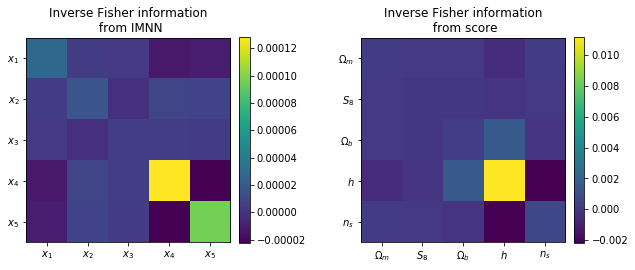

In [15]:
Finv_score = np.genfromtxt('simulators/cosmic_shear_nuisances/results_marginalized/Finv.dat')
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
plt.subplots_adjust(wspace = 0.5)
p = ax[0].imshow(Finv)
plt.colorbar(p, ax = ax[0], fraction = 0.046, pad = 0.04)
ax[0].set_xticks([0, 1, 2, 3, 4])
ax[0].set_xticklabels([r"$x_1$", r"$x_2$", r"$x_3$", r"$x_4$", r"$x_5$"])
ax[0].set_yticks([0, 1, 2, 3, 4])
ax[0].set_yticklabels([r"$x_1$", r"$x_2$", r"$x_3$", r"$x_4$", r"$x_5$"])
ax[0].set_title("Inverse Fisher information\n from IMNN")
q = ax[1].imshow(Finv_score)
plt.colorbar(q, ax = ax[1], fraction = 0.046, pad = 0.04)
ax[1].set_xticks([0, 1, 2, 3, 4])
ax[1].set_xticklabels([r"$\Omega_m$", r"$S_8$", r"$\Omega_b$", r"$h$", r"$n_s$"])
ax[1].set_yticks([0, 1, 2, 3, 4])
ax[1].set_yticklabels([r"$\Omega_m$", r"$S_8$", r"$\Omega_b$", r"$h$", r"$n_s$"])
ax[1].set_title("Inverse Fisher information\n from score");
plt.savefig("inverse_fisher_information_comparison.pdf", bbox_inches = "tight")

In [19]:
### LOAD IN THE DATA VECTOR ###
simulation = simulator(theta_fiducial, 42, simulator_args)
data = compressor(simulation, compressor_args)
summary_data = IMNN_summary(simulation, compressor_args)
print("Fiducial parameter values = ", theta_fiducial)
print("IMNN maximum likelihood estimate = ", data)
print("IMNN summaries = ", summary_data)
print("|F|", np.linalg.det(compression_network.sess.run(compression_network.test_F)))
print("|F_score|", np.linalg.det(np.linalg.inv(Finv_score)))
print("IMNN Fisher forecast =  ", np.sqrt(np.diag(Finv)))
print("Score Fisher forecast = ", np.sqrt(np.diag(Finv_score)))

Fiducial parameter values =  [0.3  0.8  0.05 0.7  0.96]
IMNN maximum likelihood estimate =  [0.2975292  0.80193955 0.05108678 0.69471085 0.9554139 ]
IMNN summaries =  [ 0.12881239 -0.00789922 -0.10476309  0.02170353 -0.0338571 ]
|F| 7.579765e+22
|F_score| 2.993775814711634e+20
IMNN Fisher forecast =   [0.00527673 0.00413764 0.00232336 0.01131339 0.00982792]
Score Fisher forecast =  [0.01466149 0.00319633 0.01760273 0.10559914 0.02583956]


In [20]:
## Create the MDN
NDE = ndes.MixtureDensityNetwork(n_inputs=5, n_outputs=5, n_components=3, n_hidden=[50,50], activations=[tf.tanh, tf.tanh])

## Create the MAF
#NDE = ndes.ConditionalMaskedAutoregressiveFlow(n_inputs=5, n_outputs=5, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh)

In [21]:
# Create the DELFI object
DelfiNDE = delfi.Delfi(data, prior, NDE, Finv, theta_fiducial, 
                       param_limits = [lower, upper],
                       param_names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s'], 
                       results_dir = "simulators/cosmic_shear/results/")



Sample parameters:   0%|          | 0/200000 [00:00<?, ?it/s]

Sample parameters:   1%|          | 1572/200000 [00:00<00:12, 15697.41it/s]

Generating fisher pre-training data...




Sample parameters:   2%|▏         | 3030/200000 [00:00<00:12, 15341.91it/s]

Sample parameters:   3%|▎         | 5125/200000 [00:00<00:11, 16680.21it/s]

Sample parameters:   4%|▎         | 7258/200000 [00:00<00:10, 17846.57it/s]

Sample parameters:   5%|▍         | 9342/200000 [00:00<00:10, 18649.16it/s]

Sample parameters:   6%|▌         | 11419/200000 [00:00<00:09, 19238.23it/s]

Sample parameters:   7%|▋         | 13439/200000 [00:00<00:09, 19515.88it/s]

Sample parameters:   8%|▊         | 15519/200000 [00:00<00:09, 19883.79it/s]

Sample parameters:   9%|▉         | 17615/200000 [00:00<00:09, 20193.97it/s]

Sample parameters:  10%|▉         | 19586/200000 [00:01<00:09, 19681.29it/s]

Sample parameters:  11%|█         | 21523/200000 [00:01<00:09, 18718.88it/s]

Sample parameters:  12%|█▏        | 23383/200000 [00:01<00:09, 18452.98it/s]

Sample parameters:  13%|█▎        | 25379/200000 [00:01<00:09, 18879.07it/s]

Sample parameters:  14%|█▎        | 27265/200000 [00:01<00:09, 185

Training the neural density estimator...




Epochs:   0%|          | 0/500 [00:21<?, ?it/s, train_loss=11.2, val_loss=-15.8]

Epochs:   0%|          | 1/500 [00:21<2:57:44, 21.37s/it, train_loss=11.2, val_loss=-15.8]

Epochs:   0%|          | 1/500 [00:42<2:57:44, 21.37s/it, train_loss=10.1, val_loss=-17]  

Epochs:   0%|          | 2/500 [00:42<2:56:36, 21.28s/it, train_loss=10.1, val_loss=-17]

Epochs:   0%|          | 2/500 [01:03<2:56:36, 21.28s/it, train_loss=14.4, val_loss=-17.5]

Epochs:   1%|          | 3/500 [01:03<2:55:19, 21.17s/it, train_loss=14.4, val_loss=-17.5]

Epochs:   1%|          | 3/500 [01:23<2:55:19, 21.17s/it, train_loss=70.5, val_loss=-17]  

Epochs:   1%|          | 4/500 [01:23<2:53:36, 21.00s/it, train_loss=70.5, val_loss=-17]

Epochs:   1%|          | 4/500 [01:44<2:53:36, 21.00s/it, train_loss=19.5, val_loss=-18.1]

Epochs:   1%|          | 5/500 [01:44<2:53:12, 21.00s/it, train_loss=19.5, val_loss=-18.1]

Epochs:   1%|          | 5/500 [02:05<2:53:12, 21.00s/it, train_loss=35.8, val_loss=-18.1]



Epochs:   8%|▊         | 42/500 [14:27<2:36:21, 20.48s/it, train_loss=37.8, val_loss=-18.6]

Epochs:   8%|▊         | 42/500 [14:47<2:36:21, 20.48s/it, train_loss=23.4, val_loss=-18.3]

Epochs:   9%|▊         | 43/500 [14:47<2:36:03, 20.49s/it, train_loss=23.4, val_loss=-18.3]

Epochs:   9%|▊         | 43/500 [15:08<2:36:03, 20.49s/it, train_loss=37.9, val_loss=-18.2]

Epochs:   9%|▉         | 44/500 [15:08<2:35:51, 20.51s/it, train_loss=37.9, val_loss=-18.2]

Epochs:   9%|▉         | 44/500 [15:28<2:35:51, 20.51s/it, train_loss=37.9, val_loss=-18.7]

Epochs:   9%|▉         | 45/500 [15:28<2:35:34, 20.51s/it, train_loss=37.9, val_loss=-18.7]

Epochs:   9%|▉         | 45/500 [15:49<2:35:34, 20.51s/it, train_loss=37.9, val_loss=-18.8]

Epochs:   9%|▉         | 46/500 [15:49<2:35:14, 20.52s/it, train_loss=37.9, val_loss=-18.8]

Epochs:   9%|▉         | 46/500 [16:10<2:35:14, 20.52s/it, train_loss=23.4, val_loss=-18.8]

Epochs:   9%|▉         | 47/500 [16:10<2:35:01, 20.53s/it, train_loss=

Training finished
Best epoch 00072, Val_loss: -18.9607
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model
Done.
Sampling approximate posterior...
Done.
Plotting the posterior (1D and 2D marginals)...
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving simulators/cosmic_shear/results/fisher_pretrain_post.pdf


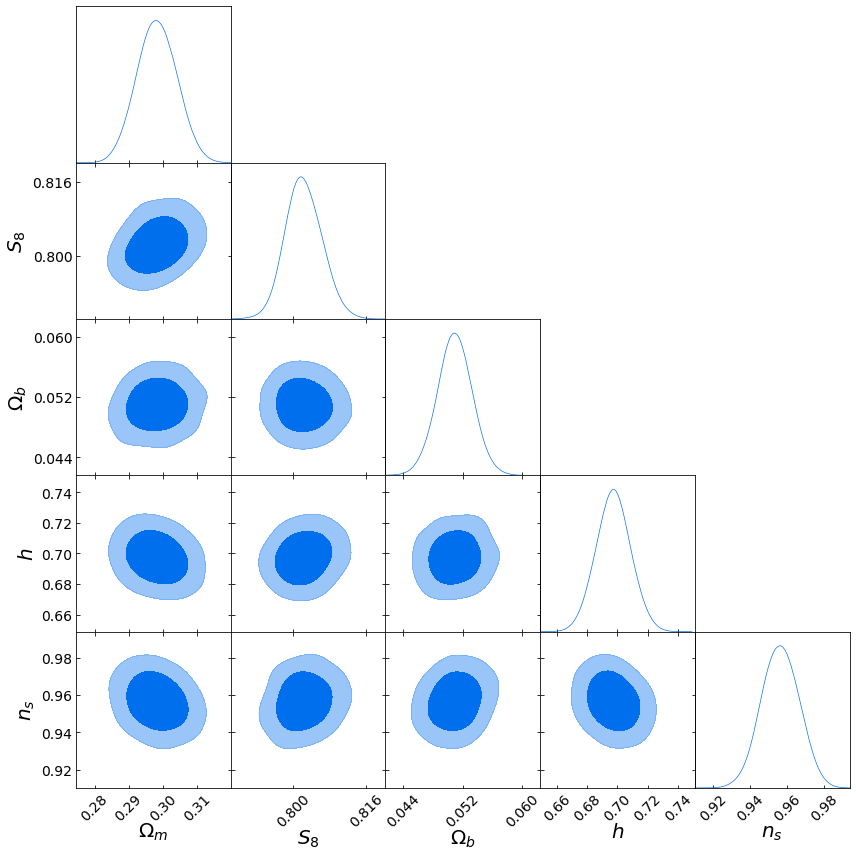

In [22]:
# Do the Fisher pre-training
DelfiNDE.fisher_pretraining(200000, prior, epochs=500, patience=20)





Simulations:   0%|          | 0/499 [00:00<?, ?it/s]

Running initial 500 sims...






Simulations:   0%|          | 1/499 [00:00<06:04,  1.37it/s]



Simulations:   0%|          | 2/499 [00:01<05:46,  1.44it/s]



Simulations:   1%|          | 3/499 [00:01<05:32,  1.49it/s]



Simulations:   1%|          | 4/499 [00:02<05:21,  1.54it/s]



Simulations:   1%|          | 5/499 [00:03<05:12,  1.58it/s]



Simulations:   1%|          | 6/499 [00:03<05:08,  1.60it/s]



Simulations:   1%|▏         | 7/499 [00:04<05:15,  1.56it/s]



Simulations:   2%|▏         | 8/499 [00:05<05:11,  1.58it/s]



Simulations:   2%|▏         | 9/499 [00:05<05:06,  1.60it/s]



Simulations:   2%|▏         | 10/499 [00:06<05:06,  1.59it/s]



Simulations:   2%|▏         | 11/499 [00:06<05:08,  1.58it/s]



Simulations:   2%|▏         | 12/499 [00:07<05:03,  1.60it/s]



Simulations:   3%|▎         | 13/499 [00:08<05:03,  1.60it/s]



Simulations:   3%|▎         | 14/499 [00:08<04:47,  1.69it/s]



Simulations:   3%|▎         | 15/499 [00:09<04:47,  1.69it/s]



Simulations:   3%|▎         | 

Simulations:  21%|██▏       | 107/499 [01:02<04:08,  1.58it/s]



Simulations:  22%|██▏       | 108/499 [01:03<04:13,  1.54it/s]



Simulations:  22%|██▏       | 109/499 [01:03<04:10,  1.56it/s]



Simulations:  22%|██▏       | 110/499 [01:04<04:03,  1.60it/s]



Simulations:  22%|██▏       | 111/499 [01:05<04:03,  1.59it/s]



Simulations:  22%|██▏       | 112/499 [01:05<03:59,  1.62it/s]



Simulations:  23%|██▎       | 113/499 [01:06<03:55,  1.64it/s]



Simulations:  23%|██▎       | 114/499 [01:06<03:45,  1.71it/s]



Simulations:  23%|██▎       | 115/499 [01:07<03:53,  1.64it/s]



Simulations:  23%|██▎       | 116/499 [01:07<03:50,  1.66it/s]



Simulations:  23%|██▎       | 117/499 [01:08<03:52,  1.64it/s]



Simulations:  24%|██▎       | 118/499 [01:09<03:54,  1.63it/s]



Simulations:  24%|██▍       | 119/499 [01:09<04:08,  1.53it/s]



Simulations:  24%|██▍       | 120/499 [01:10<04:10,  1.51it/s]



Simulations:  24%|██▍       | 121/499 [01:11<03:56,  1.60it/s]



Simulation

Simulations:  42%|████▏     | 212/499 [02:06<02:59,  1.60it/s]



Simulations:  43%|████▎     | 213/499 [02:07<03:05,  1.54it/s]



Simulations:  43%|████▎     | 214/499 [02:08<02:56,  1.62it/s]



Simulations:  43%|████▎     | 215/499 [02:08<02:43,  1.74it/s]



Simulations:  43%|████▎     | 216/499 [02:09<02:34,  1.83it/s]



Simulations:  43%|████▎     | 217/499 [02:09<02:32,  1.85it/s]



Simulations:  44%|████▎     | 218/499 [02:10<02:32,  1.85it/s]



Simulations:  44%|████▍     | 219/499 [02:10<02:37,  1.78it/s]



Simulations:  44%|████▍     | 220/499 [02:11<02:39,  1.75it/s]



Simulations:  44%|████▍     | 221/499 [02:11<02:33,  1.81it/s]



Simulations:  44%|████▍     | 222/499 [02:12<02:36,  1.77it/s]



Simulations:  45%|████▍     | 223/499 [02:13<02:45,  1.67it/s]



Simulations:  45%|████▍     | 224/499 [02:13<02:45,  1.66it/s]



Simulations:  45%|████▌     | 225/499 [02:14<02:39,  1.72it/s]



Simulations:  45%|████▌     | 226/499 [02:14<02:30,  1.82it/s]



Simulation

Simulations:  64%|██████▎   | 317/499 [03:07<01:31,  1.98it/s]



Simulations:  64%|██████▎   | 318/499 [03:07<01:32,  1.96it/s]



Simulations:  64%|██████▍   | 319/499 [03:08<01:33,  1.92it/s]



Simulations:  64%|██████▍   | 320/499 [03:08<01:34,  1.90it/s]



Simulations:  64%|██████▍   | 321/499 [03:09<01:37,  1.83it/s]



Simulations:  65%|██████▍   | 322/499 [03:10<01:39,  1.79it/s]



Simulations:  65%|██████▍   | 323/499 [03:10<01:41,  1.74it/s]



Simulations:  65%|██████▍   | 324/499 [03:11<01:36,  1.82it/s]



Simulations:  65%|██████▌   | 325/499 [03:11<01:39,  1.75it/s]



Simulations:  65%|██████▌   | 326/499 [03:12<01:39,  1.74it/s]



Simulations:  66%|██████▌   | 327/499 [03:13<01:41,  1.70it/s]



Simulations:  66%|██████▌   | 328/499 [03:13<01:41,  1.69it/s]



Simulations:  66%|██████▌   | 329/499 [03:14<01:36,  1.76it/s]



Simulations:  66%|██████▌   | 330/499 [03:14<01:31,  1.85it/s]



Simulations:  66%|██████▋   | 331/499 [03:15<01:27,  1.92it/s]



Simulation

Simulations:  85%|████████▍ | 422/499 [04:07<00:42,  1.82it/s]



Simulations:  85%|████████▍ | 423/499 [04:08<00:43,  1.75it/s]



Simulations:  85%|████████▍ | 424/499 [04:08<00:41,  1.83it/s]



Simulations:  85%|████████▌ | 425/499 [04:09<00:42,  1.76it/s]



Simulations:  85%|████████▌ | 426/499 [04:09<00:44,  1.63it/s]



Simulations:  86%|████████▌ | 427/499 [04:10<00:44,  1.62it/s]



Simulations:  86%|████████▌ | 428/499 [04:11<00:41,  1.72it/s]



Simulations:  86%|████████▌ | 429/499 [04:11<00:40,  1.71it/s]



Simulations:  86%|████████▌ | 430/499 [04:12<00:41,  1.68it/s]



Simulations:  86%|████████▋ | 431/499 [04:13<00:43,  1.58it/s]



Simulations:  87%|████████▋ | 432/499 [04:13<00:42,  1.58it/s]



Simulations:  87%|████████▋ | 433/499 [04:14<00:41,  1.60it/s]



Simulations:  87%|████████▋ | 434/499 [04:14<00:42,  1.54it/s]



Simulations:  87%|████████▋ | 435/499 [04:15<00:40,  1.57it/s]



Simulations:  87%|████████▋ | 436/499 [04:16<00:38,  1.64it/s]



Simulation

Done.







Epochs:   1%|          | 1/100 [00:00<00:22,  4.33it/s, train_loss=-17.5, val_loss=-17.5]




Epochs:   1%|          | 1/100 [00:00<00:22,  4.33it/s, train_loss=-17.5, val_loss=-17.5]




Epochs:   2%|▏         | 2/100 [00:00<00:22,  4.45it/s, train_loss=-17.5, val_loss=-17.5]




Epochs:   2%|▏         | 2/100 [00:00<00:22,  4.45it/s, train_loss=-16.9, val_loss=-16.9]




Epochs:   3%|▎         | 3/100 [00:00<00:18,  5.19it/s, train_loss=-16.9, val_loss=-16.9]




Epochs:   3%|▎         | 3/100 [00:00<00:18,  5.19it/s, train_loss=-17.4, val_loss=-17.2]




Epochs:   4%|▍         | 4/100 [00:00<00:15,  6.00it/s, train_loss=-17.4, val_loss=-17.2]




Epochs:   4%|▍         | 4/100 [00:00<00:15,  6.00it/s, train_loss=-17.6, val_loss=-17.5]




Epochs:   5%|▌         | 5/100 [00:00<00:14,  6.54it/s, train_loss=-17.6, val_loss=-17.5]




Epochs:   5%|▌         | 5/100 [00:00<00:14,  6.54it/s, train_loss=-17.4, val_loss=-17.3]




Epochs:   6%|▌         | 6/100 [00:00<00:13,  6.98it/s,

Epochs:  38%|███▊      | 38/100 [00:05<00:08,  7.09it/s, train_loss=-18.1, val_loss=-17.9]




Epochs:  39%|███▉      | 39/100 [00:05<00:08,  7.55it/s, train_loss=-18.1, val_loss=-17.9]




Epochs:  39%|███▉      | 39/100 [00:05<00:08,  7.55it/s, train_loss=-18.2, val_loss=-18.1]




Epochs:  40%|████      | 40/100 [00:05<00:09,  6.62it/s, train_loss=-18.2, val_loss=-18.1]




Epochs:  40%|████      | 40/100 [00:05<00:09,  6.62it/s, train_loss=-16.4, val_loss=-16.4]




Epochs:  41%|████      | 41/100 [00:05<00:08,  7.25it/s, train_loss=-16.4, val_loss=-16.4]




Epochs:  41%|████      | 41/100 [00:05<00:08,  7.25it/s, train_loss=-17.3, val_loss=-17.3]




Epochs:  42%|████▏     | 42/100 [00:05<00:07,  7.68it/s, train_loss=-17.3, val_loss=-17.3]




Epochs:  42%|████▏     | 42/100 [00:06<00:07,  7.68it/s, train_loss=-17.7, val_loss=-17.7]




Epochs:  43%|████▎     | 43/100 [00:06<00:06,  8.16it/s, train_loss=-17.7, val_loss=-17.7]




Epochs:  43%|████▎     | 43/100 [00:06<00:06,  8.1

Epochs:  75%|███████▌  | 75/100 [00:10<00:03,  7.37it/s, train_loss=-18.2, val_loss=-17.9]




Epochs:  76%|███████▌  | 76/100 [00:10<00:03,  7.87it/s, train_loss=-18.2, val_loss=-17.9]




Epochs:  76%|███████▌  | 76/100 [00:10<00:03,  7.87it/s, train_loss=-18.5, val_loss=-18.4]




Epochs:  77%|███████▋  | 77/100 [00:10<00:02,  8.15it/s, train_loss=-18.5, val_loss=-18.4]




Epochs:  77%|███████▋  | 77/100 [00:10<00:02,  8.15it/s, train_loss=-18.6, val_loss=-18.4]




Epochs:  78%|███████▊  | 78/100 [00:10<00:02,  8.04it/s, train_loss=-18.6, val_loss=-18.4]




Epochs:  78%|███████▊  | 78/100 [00:10<00:02,  8.04it/s, train_loss=-18.7, val_loss=-18.6]




Epochs:  79%|███████▉  | 79/100 [00:10<00:02,  8.06it/s, train_loss=-18.7, val_loss=-18.6]




Epochs:  79%|███████▉  | 79/100 [00:10<00:02,  8.06it/s, train_loss=-18.7, val_loss=-18.4]




Epochs:  80%|████████  | 80/100 [00:10<00:02,  8.24it/s, train_loss=-18.7, val_loss=-18.4]




Epochs:  80%|████████  | 80/100 [00:10<00:02,  8.2

Training finished
Best epoch 00082, Val_loss: -18.5712
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...
Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving simulators/cosmic_shear/results/seq_train_post_0.pdf


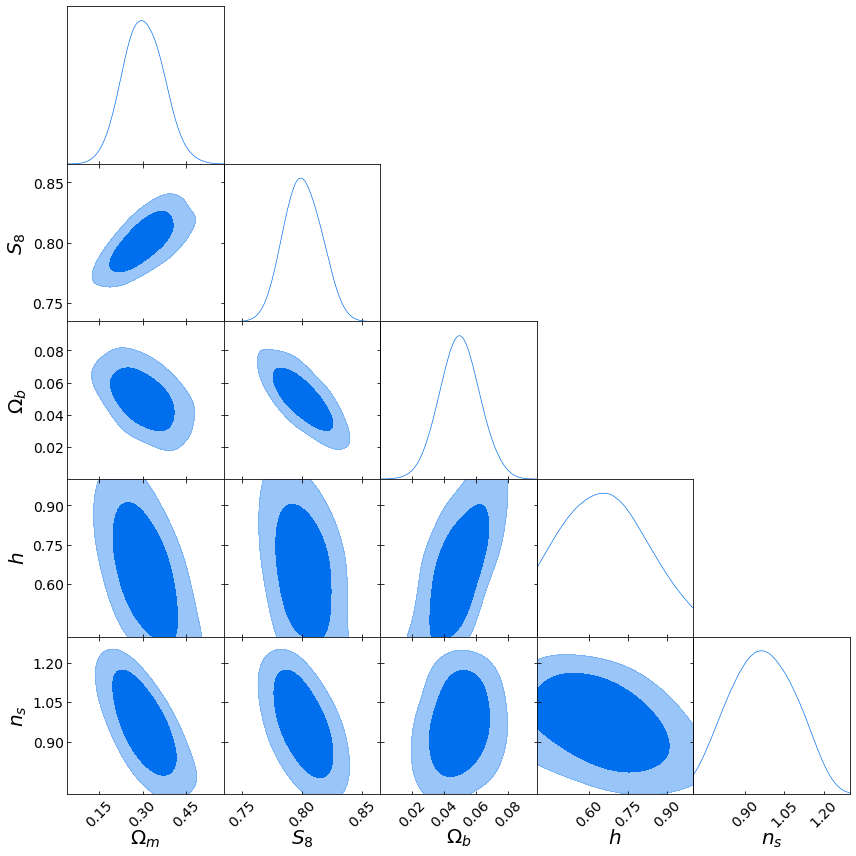

Population 1/23
Sampling proposal density...








Simulations:   0%|          | 0/499 [00:00<?, ?it/s]

Done.
Running 500 sims...








Simulations:   0%|          | 1/499 [00:00<05:14,  1.58it/s]





Simulations:   0%|          | 2/499 [00:01<05:10,  1.60it/s]





Simulations:   1%|          | 3/499 [00:01<05:02,  1.64it/s]





Simulations:   1%|          | 4/499 [00:02<04:59,  1.65it/s]





Simulations:   1%|          | 5/499 [00:02<04:47,  1.72it/s]





Simulations:   1%|          | 6/499 [00:03<04:30,  1.82it/s]





Simulations:   1%|▏         | 7/499 [00:03<04:23,  1.87it/s]





Simulations:   2%|▏         | 8/499 [00:04<04:35,  1.78it/s]





Simulations:   2%|▏         | 9/499 [00:05<04:50,  1.69it/s]





Simulations:   2%|▏         | 10/499 [00:05<04:50,  1.68it/s]





Simulations:   2%|▏         | 11/499 [00:06<04:44,  1.71it/s]





Simulations:   2%|▏         | 12/499 [00:06<04:37,  1.76it/s]





Simulations:   3%|▎         | 13/499 [00:07<04:46,  1.70it/s]





Simulations:   3%|▎         | 14/499 [00:08<04:35,  1.76it/s]





Simulations:   3%|▎         | 15/499 [00:08<04:40,  1.72it/s]





Simulations:  19%|█▉        | 97/499 [00:58<03:58,  1.68it/s]





Simulations:  20%|█▉        | 98/499 [00:58<03:51,  1.73it/s]





Simulations:  20%|█▉        | 99/499 [00:59<03:47,  1.75it/s]





Simulations:  20%|██        | 100/499 [00:59<04:03,  1.64it/s]





Simulations:  20%|██        | 101/499 [01:00<04:06,  1.61it/s]





Simulations:  20%|██        | 102/499 [01:01<04:09,  1.59it/s]





Simulations:  21%|██        | 103/499 [01:01<04:09,  1.59it/s]





Simulations:  21%|██        | 104/499 [01:02<03:54,  1.69it/s]





Simulations:  21%|██        | 105/499 [01:02<03:43,  1.76it/s]





Simulations:  21%|██        | 106/499 [01:03<03:37,  1.81it/s]





Simulations:  21%|██▏       | 107/499 [01:03<03:55,  1.66it/s]





Simulations:  22%|██▏       | 108/499 [01:04<03:59,  1.63it/s]





Simulations:  22%|██▏       | 109/499 [01:05<04:06,  1.58it/s]





Simulations:  22%|██▏       | 110/499 [01:05<03:59,  1.62it/s]





Simulations:  22%|██▏       | 111/499 [01:06<04:03,

Simulator returns exception for parameter values: [0.13520868 0.76668491 0.05594531 0.87778062 1.06052009] (rank 0)
Simulator returns exception for parameter values: [0.13520868 0.76668491 0.05594531 0.87778062 1.06052009] (rank 0)
Simulator returns exception for parameter values: [0.13520868 0.76668491 0.05594531 0.87778062 1.06052009] (rank 0)
Simulator returns exception for parameter values: [0.08544568 0.75805934 0.0567863  0.95051469 1.08400236] (rank 0)
Simulator returns exception for parameter values: [0.1481601  0.7706941  0.05713617 0.90378041 1.02577022] (rank 0)
Simulator returns exception for parameter values: [0.12695268 0.76712414 0.05902111 0.92951073 1.0433149 ] (rank 0)
Simulator returns exception for parameter values: [0.14918574 0.77465068 0.05572609 0.91610355 1.0120237 ] (rank 0)








Simulations:  26%|██▌       | 129/499 [01:18<06:11,  1.01s/it]





Simulations:  26%|██▌       | 130/499 [01:18<05:26,  1.13it/s]





Simulations:  26%|██▋       | 131/499 [01:19<04:59,  1.23it/s]





Simulations:  26%|██▋       | 132/499 [01:19<04:33,  1.34it/s]

Simulator returns exception for parameter values: [0.13970246 0.76914831 0.05866343 0.85745843 1.0783961 ] (rank 0)
Simulator returns exception for parameter values: [0.13546425 0.76815735 0.05879881 0.86247504 1.08033299] (rank 0)
Simulator returns exception for parameter values: [0.13546425 0.76815735 0.05879881 0.86247504 1.08033299] (rank 0)
Simulator returns exception for parameter values: [0.13503084 0.76812573 0.05885727 0.8626049  1.08120995] (rank 0)
Simulator returns exception for parameter values: [0.13503084 0.76812573 0.05885727 0.8626049  1.08120995] (rank 0)
Simulator returns exception for parameter values: [0.13503084 0.76812573 0.05885727 0.8626049  1.08120995] (rank 0)
Simulator returns exception for parameter values: [0.11062798 0.76415934 0.05931548 0.85526199 1.12430085] (rank 0)
Simulator returns exception for parameter values: [0.11062798 0.76415934 0.05931548 0.85526199 1.12430085] (rank 0)
Simulator returns exception for parameter values: [0.13718201 0.75668116







Simulations:  27%|██▋       | 133/499 [01:24<10:55,  1.79s/it]





Simulations:  27%|██▋       | 134/499 [01:24<08:25,  1.39s/it]





Simulations:  27%|██▋       | 135/499 [01:25<06:45,  1.11s/it]

Simulator returns exception for parameter values: [0.13913797 0.75121535 0.07395418 0.78222429 1.18120588] (rank 0)
Simulator returns exception for parameter values: [0.12277994 0.73501081 0.07773687 0.79676527 1.1867755 ] (rank 0)
Simulator returns exception for parameter values: [0.12277994 0.73501081 0.07773687 0.79676527 1.1867755 ] (rank 0)
Simulator returns exception for parameter values: [0.12277994 0.73501081 0.07773687 0.79676527 1.1867755 ] (rank 0)
Simulator returns exception for parameter values: [0.12277994 0.73501081 0.07773687 0.79676527 1.1867755 ] (rank 0)
Simulator returns exception for parameter values: [0.1308155  0.73749877 0.07662107 0.78864421 1.17855126] (rank 0)
Simulator returns exception for parameter values: [0.14410684 0.74337444 0.07030353 0.75249475 1.17113198] (rank 0)
Simulator returns exception for parameter values: [0.14410684 0.74337444 0.07030353 0.75249475 1.17113198] (rank 0)
Simulator returns exception for parameter values: [0.14919395 0.74593228







Simulations:  27%|██▋       | 136/499 [01:27<09:11,  1.52s/it]





Simulations:  27%|██▋       | 137/499 [01:28<07:27,  1.24s/it]





Simulations:  28%|██▊       | 138/499 [01:28<06:04,  1.01s/it]





Simulations:  28%|██▊       | 139/499 [01:29<05:32,  1.08it/s]





Simulations:  28%|██▊       | 140/499 [01:29<04:56,  1.21it/s]





Simulations:  28%|██▊       | 141/499 [01:30<04:20,  1.37it/s]





Simulations:  28%|██▊       | 142/499 [01:30<03:51,  1.54it/s]





Simulations:  29%|██▊       | 143/499 [01:31<03:28,  1.71it/s]





Simulations:  29%|██▉       | 144/499 [01:31<03:27,  1.71it/s]





Simulations:  29%|██▉       | 145/499 [01:32<03:37,  1.63it/s]





Simulations:  29%|██▉       | 146/499 [01:33<03:35,  1.63it/s]





Simulations:  29%|██▉       | 147/499 [01:33<03:26,  1.71it/s]





Simulations:  30%|██▉       | 148/499 [01:34<03:18,  1.77it/s]





Simulations:  30%|██▉       | 149/499 [01:34<03:14,  1.80it/s]





Simulations:  30%|███       | 150/499 [01:

Simulations:  46%|████▋     | 231/499 [02:20<02:22,  1.88it/s]





Simulations:  46%|████▋     | 232/499 [02:21<02:26,  1.82it/s]





Simulations:  47%|████▋     | 233/499 [02:21<02:21,  1.88it/s]





Simulations:  47%|████▋     | 234/499 [02:22<02:18,  1.91it/s]





Simulations:  47%|████▋     | 235/499 [02:22<02:25,  1.81it/s]





Simulations:  47%|████▋     | 236/499 [02:23<02:28,  1.77it/s]





Simulations:  47%|████▋     | 237/499 [02:24<02:32,  1.72it/s]





Simulations:  48%|████▊     | 238/499 [02:24<02:23,  1.82it/s]





Simulations:  48%|████▊     | 239/499 [02:25<02:15,  1.91it/s]





Simulations:  48%|████▊     | 240/499 [02:25<02:13,  1.94it/s]





Simulations:  48%|████▊     | 241/499 [02:26<02:09,  1.99it/s]





Simulations:  48%|████▊     | 242/499 [02:26<02:06,  2.03it/s]





Simulations:  49%|████▊     | 243/499 [02:27<02:04,  2.05it/s]





Simulations:  49%|████▉     | 244/499 [02:27<02:02,  2.08it/s]





Simulations:  49%|████▉     | 245/499 [02:27<02:

Simulator returns exception for parameter values: [0.15657077 0.76937716 0.07009481 0.93852759 1.08159444] (rank 0)
Simulator returns exception for parameter values: [0.15673435 0.76939847 0.0700924  0.93848952 1.08134682] (rank 0)








Simulations:  54%|█████▍    | 271/499 [02:42<02:17,  1.66it/s]





Simulations:  55%|█████▍    | 272/499 [02:43<02:16,  1.66it/s]

Simulator returns exception for parameter values: [0.14926575 0.76657534 0.07148289 0.9500628  1.08619723] (rank 0)
Simulator returns exception for parameter values: [0.14926575 0.76657534 0.07148289 0.9500628  1.08619723] (rank 0)








Simulations:  55%|█████▍    | 273/499 [02:44<02:44,  1.37it/s]





Simulations:  55%|█████▍    | 274/499 [02:45<02:34,  1.45it/s]





Simulations:  55%|█████▌    | 275/499 [02:45<02:20,  1.59it/s]





Simulations:  55%|█████▌    | 276/499 [02:46<02:19,  1.60it/s]





Simulations:  56%|█████▌    | 277/499 [02:46<02:16,  1.63it/s]





Simulations:  56%|█████▌    | 278/499 [02:47<02:14,  1.65it/s]





Simulations:  56%|█████▌    | 279/499 [02:48<02:16,  1.61it/s]





Simulations:  56%|█████▌    | 280/499 [02:48<02:15,  1.61it/s]





Simulations:  56%|█████▋    | 281/499 [02:49<02:14,  1.62it/s]





Simulations:  57%|█████▋    | 282/499 [02:49<02:13,  1.63it/s]





Simulations:  57%|█████▋    | 283/499 [02:50<02:09,  1.67it/s]





Simulations:  57%|█████▋    | 284/499 [02:50<01:59,  1.79it/s]





Simulations:  57%|█████▋    | 285/499 [02:51<02:12,  1.61it/s]





Simulations:  57%|█████▋    | 286/499 [02:52<02:07,  1.66it/s]





Simulations:  58%|█████▊    | 287/499 [02:

Simulations:  74%|███████▎  | 368/499 [03:39<01:17,  1.69it/s]





Simulations:  74%|███████▍  | 369/499 [03:40<01:16,  1.71it/s]





Simulations:  74%|███████▍  | 370/499 [03:40<01:18,  1.65it/s]





Simulations:  74%|███████▍  | 371/499 [03:41<01:19,  1.61it/s]





Simulations:  75%|███████▍  | 372/499 [03:42<01:17,  1.64it/s]





Simulations:  75%|███████▍  | 373/499 [03:42<01:18,  1.61it/s]





Simulations:  75%|███████▍  | 374/499 [03:43<01:16,  1.63it/s]





Simulations:  75%|███████▌  | 375/499 [03:44<01:18,  1.58it/s]





Simulations:  75%|███████▌  | 376/499 [03:44<01:15,  1.63it/s]





Simulations:  76%|███████▌  | 377/499 [03:45<01:10,  1.73it/s]





Simulations:  76%|███████▌  | 378/499 [03:45<01:06,  1.82it/s]





Simulations:  76%|███████▌  | 379/499 [03:46<01:07,  1.77it/s]





Simulations:  76%|███████▌  | 380/499 [03:46<01:10,  1.68it/s]





Simulations:  76%|███████▋  | 381/499 [03:47<01:11,  1.65it/s]





Simulations:  77%|███████▋  | 382/499 [03:48<01:

Simulations:  93%|█████████▎| 463/499 [04:32<00:22,  1.62it/s]





Simulations:  93%|█████████▎| 464/499 [04:33<00:21,  1.61it/s]





Simulations:  93%|█████████▎| 465/499 [04:33<00:19,  1.74it/s]





Simulations:  93%|█████████▎| 466/499 [04:34<00:19,  1.71it/s]





Simulations:  94%|█████████▎| 467/499 [04:35<00:19,  1.63it/s]





Simulations:  94%|█████████▍| 468/499 [04:35<00:19,  1.58it/s]





Simulations:  94%|█████████▍| 469/499 [04:36<00:19,  1.57it/s]





Simulations:  94%|█████████▍| 470/499 [04:37<00:17,  1.62it/s]





Simulations:  94%|█████████▍| 471/499 [04:37<00:16,  1.66it/s]





Simulations:  95%|█████████▍| 472/499 [04:38<00:16,  1.64it/s]





Simulations:  95%|█████████▍| 473/499 [04:38<00:16,  1.61it/s]





Simulations:  95%|█████████▍| 474/499 [04:39<00:15,  1.62it/s]





Simulations:  95%|█████████▌| 475/499 [04:40<00:14,  1.64it/s]





Simulations:  95%|█████████▌| 476/499 [04:40<00:13,  1.76it/s]





Simulations:  96%|█████████▌| 477/499 [04:41<00:

Done.









Epochs:   1%|          | 1/100 [00:00<00:23,  4.23it/s, train_loss=-16.3, val_loss=-16.7]






Epochs:   1%|          | 1/100 [00:00<00:23,  4.23it/s, train_loss=-16.4, val_loss=-16.7]






Epochs:   2%|▏         | 2/100 [00:00<00:21,  4.52it/s, train_loss=-16.4, val_loss=-16.7]






Epochs:   2%|▏         | 2/100 [00:00<00:21,  4.52it/s, train_loss=-16.5, val_loss=-16.9]






Epochs:   3%|▎         | 3/100 [00:00<00:21,  4.59it/s, train_loss=-16.5, val_loss=-16.9]






Epochs:   3%|▎         | 3/100 [00:00<00:21,  4.59it/s, train_loss=-16.8, val_loss=-17]  






Epochs:   4%|▍         | 4/100 [00:00<00:19,  5.00it/s, train_loss=-16.8, val_loss=-17]






Epochs:   4%|▍         | 4/100 [00:00<00:19,  5.00it/s, train_loss=-16.7, val_loss=-17]






Epochs:   5%|▌         | 5/100 [00:00<00:18,  5.09it/s, train_loss=-16.7, val_loss=-17]






Epochs:   5%|▌         | 5/100 [00:01<00:18,  5.09it/s, train_loss=-16.9, val_loss=-17.3]






Epochs:   6%|▌         | 6/100 [00:01<0

Epochs:  35%|███▌      | 35/100 [00:05<00:08,  7.41it/s, train_loss=-17.7, val_loss=-17.9]






Epochs:  36%|███▌      | 36/100 [00:05<00:08,  7.86it/s, train_loss=-17.7, val_loss=-17.9]






Epochs:  36%|███▌      | 36/100 [00:05<00:08,  7.86it/s, train_loss=-18, val_loss=-18.1]  






Epochs:  37%|███▋      | 37/100 [00:05<00:07,  8.22it/s, train_loss=-18, val_loss=-18.1]






Epochs:  37%|███▋      | 37/100 [00:05<00:07,  8.22it/s, train_loss=-18.1, val_loss=-18.2]






Epochs:  38%|███▊      | 38/100 [00:05<00:07,  8.40it/s, train_loss=-18.1, val_loss=-18.2]






Epochs:  38%|███▊      | 38/100 [00:05<00:07,  8.40it/s, train_loss=-17.9, val_loss=-18]  






Epochs:  39%|███▉      | 39/100 [00:05<00:07,  8.35it/s, train_loss=-17.9, val_loss=-18]






Epochs:  39%|███▉      | 39/100 [00:06<00:07,  8.35it/s, train_loss=-18, val_loss=-18]  






Epochs:  40%|████      | 40/100 [00:06<00:07,  8.56it/s, train_loss=-18, val_loss=-18]






Epochs:  40%|████      | 40/100 [00:06<0

Epochs:  70%|███████   | 70/100 [00:10<00:03,  7.98it/s, train_loss=-18.5, val_loss=-18.7]






Epochs:  70%|███████   | 70/100 [00:10<00:03,  7.98it/s, train_loss=-17.1, val_loss=-17.2]






Epochs:  71%|███████   | 71/100 [00:10<00:03,  8.09it/s, train_loss=-17.1, val_loss=-17.2]






Epochs:  71%|███████   | 71/100 [00:10<00:03,  8.09it/s, train_loss=-18.6, val_loss=-18.6]






Epochs:  72%|███████▏  | 72/100 [00:10<00:03,  7.98it/s, train_loss=-18.6, val_loss=-18.6]






Epochs:  72%|███████▏  | 72/100 [00:10<00:03,  7.98it/s, train_loss=-18.5, val_loss=-18.5]






Epochs:  73%|███████▎  | 73/100 [00:10<00:03,  8.26it/s, train_loss=-18.5, val_loss=-18.5]






Epochs:  73%|███████▎  | 73/100 [00:10<00:03,  8.26it/s, train_loss=-18.6, val_loss=-18.7]






Epochs:  74%|███████▍  | 74/100 [00:10<00:03,  8.40it/s, train_loss=-18.6, val_loss=-18.7]






Epochs:  74%|███████▍  | 74/100 [00:10<00:03,  8.40it/s, train_loss=-18.6, val_loss=-18.8]






Epochs:  75%|███████▌  | 75/10

Training finished
Best epoch 00089, Val_loss: -18.9536
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...
Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving simulators/cosmic_shear/results/seq_train_post_1.pdf


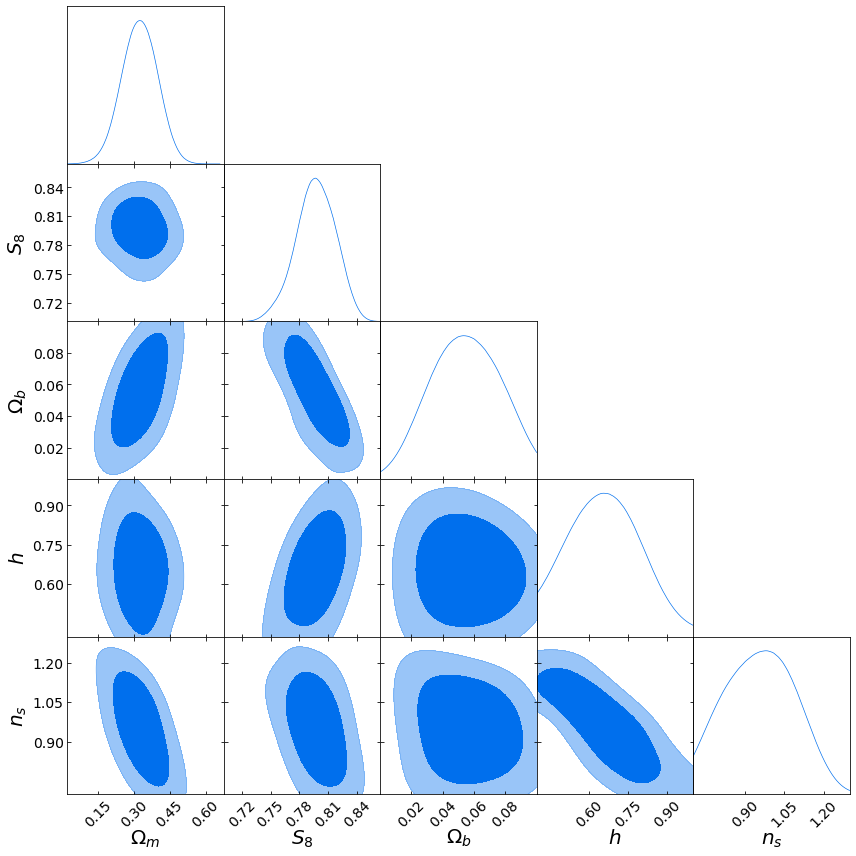

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


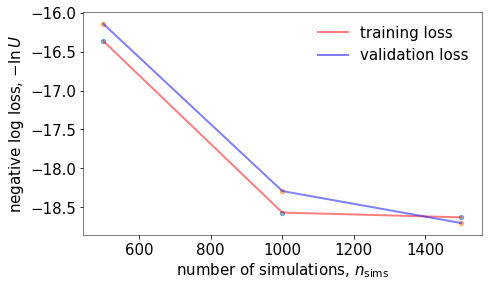

Population 2/23
Sampling proposal density...










Simulations:   0%|          | 0/499 [00:00<?, ?it/s]

Done.
Running 500 sims...










Simulations:   0%|          | 1/499 [00:00<04:21,  1.90it/s]







Simulations:   0%|          | 2/499 [00:01<04:25,  1.87it/s]







Simulations:   1%|          | 3/499 [00:01<04:26,  1.86it/s]







Simulations:   1%|          | 4/499 [00:02<04:33,  1.81it/s]







Simulations:   1%|          | 5/499 [00:02<04:40,  1.76it/s]







Simulations:   1%|          | 6/499 [00:03<04:49,  1.70it/s]







Simulations:   1%|▏         | 7/499 [00:04<04:56,  1.66it/s]







Simulations:   2%|▏         | 8/499 [00:04<04:37,  1.77it/s]







Simulations:   2%|▏         | 9/499 [00:05<04:21,  1.88it/s]







Simulations:   2%|▏         | 10/499 [00:05<04:08,  1.97it/s]







Simulations:   2%|▏         | 11/499 [00:05<04:01,  2.02it/s]







Simulations:   2%|▏         | 12/499 [00:06<04:11,  1.94it/s]







Simulations:   3%|▎         | 13/499 [00:07<04:22,  1.85it/s]







Simulations:   3%|▎         | 14/499 [00:07<04:17,  1.88it/s]







Simulations:   3%|▎         | 15/49

Simulations:  18%|█▊        | 89/499 [00:50<03:56,  1.73it/s]







Simulations:  18%|█▊        | 90/499 [00:51<03:56,  1.73it/s]







Simulations:  18%|█▊        | 91/499 [00:52<04:07,  1.65it/s]







Simulations:  18%|█▊        | 92/499 [00:52<03:54,  1.74it/s]







Simulations:  19%|█▊        | 93/499 [00:53<03:59,  1.69it/s]







Simulations:  19%|█▉        | 94/499 [00:53<03:49,  1.76it/s]







Simulations:  19%|█▉        | 95/499 [00:54<03:43,  1.81it/s]







Simulations:  19%|█▉        | 96/499 [00:54<03:36,  1.86it/s]

Simulator returns exception for parameter values: [0.14440655 0.81625933 0.04106247 0.99208356 0.95434023] (rank 0)
Simulator returns exception for parameter values: [0.14440655 0.81625933 0.04106247 0.99208356 0.95434023] (rank 0)
Simulator returns exception for parameter values: [0.14440655 0.81625933 0.04106247 0.99208356 0.95434023] (rank 0)
Simulator returns exception for parameter values: [0.14440655 0.81625933 0.04106247 0.99208356 0.95434023] (rank 0)










Simulations:  19%|█▉        | 97/499 [00:56<05:09,  1.30it/s]







Simulations:  20%|█▉        | 98/499 [00:56<04:37,  1.45it/s]







Simulations:  20%|█▉        | 99/499 [00:57<04:12,  1.59it/s]







Simulations:  20%|██        | 100/499 [00:57<03:55,  1.70it/s]







Simulations:  20%|██        | 101/499 [00:58<03:42,  1.79it/s]







Simulations:  20%|██        | 102/499 [00:58<03:42,  1.78it/s]







Simulations:  21%|██        | 103/499 [00:59<03:41,  1.79it/s]







Simulations:  21%|██        | 104/499 [00:59<03:41,  1.78it/s]







Simulations:  21%|██        | 105/499 [01:00<03:31,  1.86it/s]







Simulations:  21%|██        | 106/499 [01:00<03:28,  1.88it/s]







Simulations:  21%|██▏       | 107/499 [01:01<03:33,  1.84it/s]







Simulations:  22%|██▏       | 108/499 [01:02<03:40,  1.77it/s]







Simulations:  22%|██▏       | 109/499 [01:02<03:42,  1.75it/s]







Simulations:  22%|██▏       | 110/499 [01:03<03:56,  1.64it/s]







Simulations:  2

Simulations:  37%|███▋      | 184/499 [01:46<03:08,  1.67it/s]







Simulations:  37%|███▋      | 185/499 [01:47<03:16,  1.60it/s]







Simulations:  37%|███▋      | 186/499 [01:48<03:14,  1.61it/s]







Simulations:  37%|███▋      | 187/499 [01:48<03:12,  1.62it/s]







Simulations:  38%|███▊      | 188/499 [01:49<03:00,  1.73it/s]







Simulations:  38%|███▊      | 189/499 [01:49<03:01,  1.71it/s]







Simulations:  38%|███▊      | 190/499 [01:50<02:58,  1.73it/s]







Simulations:  38%|███▊      | 191/499 [01:50<02:56,  1.75it/s]







Simulations:  38%|███▊      | 192/499 [01:51<02:57,  1.73it/s]







Simulations:  39%|███▊      | 193/499 [01:52<02:57,  1.73it/s]







Simulations:  39%|███▉      | 194/499 [01:52<02:55,  1.74it/s]







Simulations:  39%|███▉      | 195/499 [01:53<02:53,  1.75it/s]







Simulations:  39%|███▉      | 196/499 [01:53<02:51,  1.76it/s]







Simulations:  39%|███▉      | 197/499 [01:54<03:05,  1.63it/s]







Simulations:  40%|██

Simulations:  54%|█████▍    | 271/499 [02:38<02:24,  1.57it/s]







Simulations:  55%|█████▍    | 272/499 [02:39<02:25,  1.56it/s]







Simulations:  55%|█████▍    | 273/499 [02:40<02:25,  1.56it/s]







Simulations:  55%|█████▍    | 274/499 [02:41<02:29,  1.51it/s]







Simulations:  55%|█████▌    | 275/499 [02:41<02:25,  1.54it/s]







Simulations:  55%|█████▌    | 276/499 [02:42<02:26,  1.52it/s]







Simulations:  56%|█████▌    | 277/499 [02:42<02:21,  1.57it/s]







Simulations:  56%|█████▌    | 278/499 [02:43<02:10,  1.69it/s]







Simulations:  56%|█████▌    | 279/499 [02:43<02:09,  1.70it/s]







Simulations:  56%|█████▌    | 280/499 [02:44<02:08,  1.71it/s]







Simulations:  56%|█████▋    | 281/499 [02:45<02:10,  1.67it/s]







Simulations:  57%|█████▋    | 282/499 [02:45<02:12,  1.63it/s]







Simulations:  57%|█████▋    | 283/499 [02:46<02:16,  1.58it/s]







Simulations:  57%|█████▋    | 284/499 [02:47<02:20,  1.53it/s]







Simulations:  57%|██

Simulations:  72%|███████▏  | 358/499 [03:30<01:21,  1.73it/s]







Simulations:  72%|███████▏  | 359/499 [03:31<01:25,  1.63it/s]







Simulations:  72%|███████▏  | 360/499 [03:32<01:24,  1.64it/s]







Simulations:  72%|███████▏  | 361/499 [03:32<01:18,  1.75it/s]







Simulations:  73%|███████▎  | 362/499 [03:33<01:15,  1.82it/s]







Simulations:  73%|███████▎  | 363/499 [03:33<01:11,  1.89it/s]







Simulations:  73%|███████▎  | 364/499 [03:34<01:13,  1.83it/s]







Simulations:  73%|███████▎  | 365/499 [03:35<01:19,  1.69it/s]







Simulations:  73%|███████▎  | 366/499 [03:35<01:20,  1.66it/s]







Simulations:  74%|███████▎  | 367/499 [03:36<01:21,  1.62it/s]







Simulations:  74%|███████▎  | 368/499 [03:36<01:23,  1.57it/s]







Simulations:  74%|███████▍  | 369/499 [03:37<01:26,  1.50it/s]







Simulations:  74%|███████▍  | 370/499 [03:38<01:28,  1.45it/s]







Simulations:  74%|███████▍  | 371/499 [03:39<01:28,  1.45it/s]







Simulations:  75%|██

Simulations:  89%|████████▉ | 445/499 [04:22<00:32,  1.68it/s]







Simulations:  89%|████████▉ | 446/499 [04:22<00:30,  1.71it/s]







Simulations:  90%|████████▉ | 447/499 [04:23<00:30,  1.71it/s]







Simulations:  90%|████████▉ | 448/499 [04:23<00:28,  1.80it/s]







Simulations:  90%|████████▉ | 449/499 [04:24<00:28,  1.75it/s]







Simulations:  90%|█████████ | 450/499 [04:25<00:29,  1.68it/s]







Simulations:  90%|█████████ | 451/499 [04:25<00:29,  1.62it/s]







Simulations:  91%|█████████ | 452/499 [04:26<00:29,  1.61it/s]







Simulations:  91%|█████████ | 453/499 [04:26<00:29,  1.59it/s]







Simulations:  91%|█████████ | 454/499 [04:27<00:27,  1.65it/s]







Simulations:  91%|█████████ | 455/499 [04:28<00:24,  1.78it/s]







Simulations:  91%|█████████▏| 456/499 [04:28<00:23,  1.81it/s]







Simulations:  92%|█████████▏| 457/499 [04:29<00:23,  1.78it/s]







Simulations:  92%|█████████▏| 458/499 [04:29<00:23,  1.77it/s]







Simulations:  92%|██

Simulator returns exception for parameter values: [0.14288578 0.8183574  0.00571827 0.7520895  1.01167983] (rank 0)
Simulator returns exception for parameter values: [0.14288578 0.8183574  0.00571827 0.7520895  1.01167983] (rank 0)
Simulator returns exception for parameter values: [0.14288578 0.8183574  0.00571827 0.7520895  1.01167983] (rank 0)
Simulator returns exception for parameter values: [0.14471509 0.8179528  0.00703034 0.74428689 1.02533295] (rank 0)










Simulations:  97%|█████████▋| 483/499 [04:43<00:10,  1.48it/s]







Simulations:  97%|█████████▋| 484/499 [04:44<00:09,  1.62it/s]







Simulations:  97%|█████████▋| 485/499 [04:44<00:07,  1.76it/s]







Simulations:  97%|█████████▋| 486/499 [04:45<00:06,  1.87it/s]







Simulations:  98%|█████████▊| 487/499 [04:45<00:06,  1.94it/s]







Simulations:  98%|█████████▊| 488/499 [04:46<00:05,  1.98it/s]







Simulations:  98%|█████████▊| 489/499 [04:46<00:05,  2.00it/s]







Simulations:  98%|█████████▊| 490/499 [04:47<00:04,  1.92it/s]







Simulations:  98%|█████████▊| 491/499 [04:47<00:04,  1.91it/s]







Simulations:  99%|█████████▊| 492/499 [04:48<00:03,  1.99it/s]







Simulations:  99%|█████████▉| 493/499 [04:48<00:03,  1.91it/s]







Simulations:  99%|█████████▉| 494/499 [04:49<00:02,  1.82it/s]







Simulations:  99%|█████████▉| 495/499 [04:49<00:02,  1.81it/s]







Simulations:  99%|█████████▉| 496/499 [04:50<00:01,  1.72it/s]







Simulations:

Done.











Epochs:   1%|          | 1/100 [00:00<00:23,  4.16it/s, train_loss=-18.4, val_loss=-18.4]








Epochs:   1%|          | 1/100 [00:00<00:23,  4.16it/s, train_loss=-18.6, val_loss=-18.6]








Epochs:   2%|▏         | 2/100 [00:00<00:23,  4.15it/s, train_loss=-18.6, val_loss=-18.6]








Epochs:   2%|▏         | 2/100 [00:00<00:23,  4.15it/s, train_loss=-18.4, val_loss=-18.4]








Epochs:   3%|▎         | 3/100 [00:00<00:19,  4.98it/s, train_loss=-18.4, val_loss=-18.4]








Epochs:   3%|▎         | 3/100 [00:00<00:19,  4.98it/s, train_loss=-18.6, val_loss=-18.5]








Epochs:   4%|▍         | 4/100 [00:00<00:17,  5.64it/s, train_loss=-18.6, val_loss=-18.5]








Epochs:   4%|▍         | 4/100 [00:00<00:17,  5.64it/s, train_loss=-18.4, val_loss=-18.4]








Epochs:   5%|▌         | 5/100 [00:00<00:15,  6.24it/s, train_loss=-18.4, val_loss=-18.4]








Epochs:   5%|▌         | 5/100 [00:00<00:15,  6.24it/s, train_loss=-18.7, val_loss=-18.6]








Epochs:   6

Training finished
Best epoch 00024, Val_loss: -18.8476
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...
Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving simulators/cosmic_shear/results/seq_train_post_2.pdf


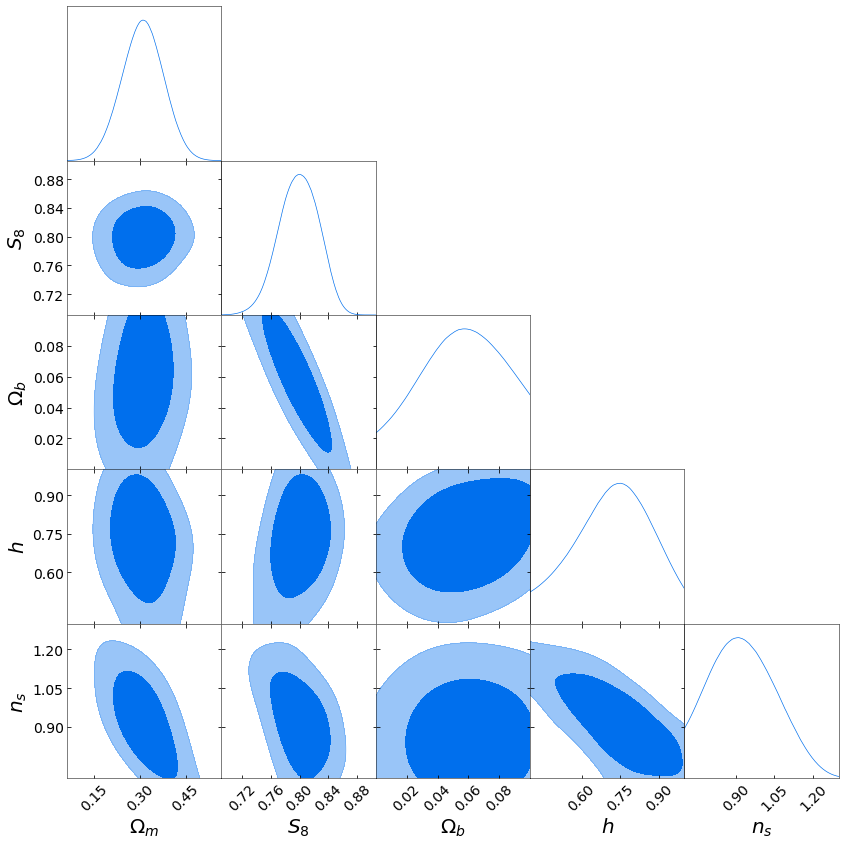

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


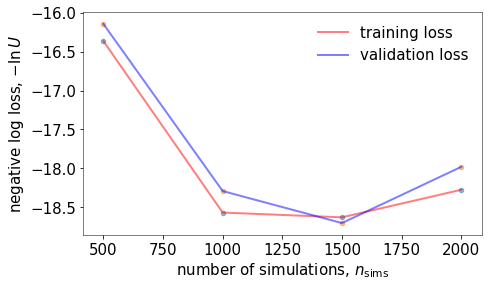

Population 3/23
Sampling proposal density...












Simulations:   0%|          | 0/499 [00:00<?, ?it/s]

Done.
Running 500 sims...












Simulations:   0%|          | 1/499 [00:00<05:01,  1.65it/s]









Simulations:   0%|          | 2/499 [00:01<05:04,  1.63it/s]









Simulations:   1%|          | 3/499 [00:01<04:52,  1.70it/s]

Simulator returns exception for parameter values: [0.17789152 0.75413516 0.07709613 0.80573401 1.05774542] (rank 0)
Simulator returns exception for parameter values: [0.18106625 0.75910087 0.07546752 0.81846194 1.0487656 ] (rank 0)
Simulator returns exception for parameter values: [0.18106625 0.75910087 0.07546752 0.81846194 1.0487656 ] (rank 0)
Simulator returns exception for parameter values: [0.18106625 0.75910087 0.07546752 0.81846194 1.0487656 ] (rank 0)
Simulator returns exception for parameter values: [0.18136855 0.7588424  0.07602459 0.8147562  1.05206352] (rank 0)












Simulations:   1%|          | 4/499 [00:03<06:45,  1.22it/s]









Simulations:   1%|          | 5/499 [00:03<06:07,  1.34it/s]









Simulations:   1%|          | 6/499 [00:04<05:46,  1.42it/s]









Simulations:   1%|▏         | 7/499 [00:05<05:44,  1.43it/s]









Simulations:   2%|▏         | 8/499 [00:05<05:33,  1.47it/s]









Simulations:   2%|▏         | 9/499 [00:06<05:23,  1.52it/s]

Simulator returns exception for parameter values: [0.17316121 0.73249378 0.09280423 0.61615025 1.26749222] (rank 0)
Simulator returns exception for parameter values: [0.17316121 0.73249378 0.09280423 0.61615025 1.26749222] (rank 0)












Simulations:   2%|▏         | 10/499 [00:07<05:54,  1.38it/s]









Simulations:   2%|▏         | 11/499 [00:07<05:35,  1.45it/s]









Simulations:   2%|▏         | 12/499 [00:08<05:24,  1.50it/s]









Simulations:   3%|▎         | 13/499 [00:08<05:08,  1.58it/s]









Simulations:   3%|▎         | 14/499 [00:09<04:47,  1.69it/s]









Simulations:   3%|▎         | 15/499 [00:09<04:24,  1.83it/s]









Simulations:   3%|▎         | 16/499 [00:10<04:09,  1.93it/s]









Simulations:   3%|▎         | 17/499 [00:10<03:59,  2.01it/s]

Simulator returns exception for parameter values: [0.18035915 0.76800858 0.072847   0.8549163  1.01746858] (rank 0)
Simulator returns exception for parameter values: [0.18035915 0.76800858 0.072847   0.8549163  1.01746858] (rank 0)












Simulations:   4%|▎         | 18/499 [00:11<04:55,  1.63it/s]









Simulations:   4%|▍         | 19/499 [00:12<05:00,  1.60it/s]









Simulations:   4%|▍         | 20/499 [00:12<05:00,  1.60it/s]









Simulations:   4%|▍         | 21/499 [00:13<04:47,  1.66it/s]









Simulations:   4%|▍         | 22/499 [00:14<04:42,  1.69it/s]









Simulations:   5%|▍         | 23/499 [00:14<04:45,  1.67it/s]









Simulations:   5%|▍         | 24/499 [00:15<04:43,  1.68it/s]









Simulations:   5%|▌         | 25/499 [00:15<04:45,  1.66it/s]









Simulations:   5%|▌         | 26/499 [00:16<04:43,  1.67it/s]









Simulations:   5%|▌         | 27/499 [00:17<04:49,  1.63it/s]









Simulations:   6%|▌         | 28/499 [00:17<04:45,  1.65it/s]









Simulations:   6%|▌         | 29/499 [00:18<04:25,  1.77it/s]









Simulations:   6%|▌         | 30/499 [00:18<04:10,  1.87it/s]









Simulations:   6%|▌         | 31/499 [00:19<03:53,  2.00it/s]







Simulator returns exception for parameter values: [0.15877047 0.81376241 0.01593139 0.50759428 1.27707502] (rank 0)
Simulator returns exception for parameter values: [0.15877047 0.81376241 0.01593139 0.50759428 1.27707502] (rank 0)
Simulator returns exception for parameter values: [0.15877047 0.81376241 0.01593139 0.50759428 1.27707502] (rank 0)
Simulator returns exception for parameter values: [0.15877047 0.81376241 0.01593139 0.50759428 1.27707502] (rank 0)
Simulator returns exception for parameter values: [0.15877047 0.81376241 0.01593139 0.50759428 1.27707502] (rank 0)
Simulator returns exception for parameter values: [0.15877047 0.81376241 0.01593139 0.50759428 1.27707502] (rank 0)
Simulator returns exception for parameter values: [0.15877047 0.81376241 0.01593139 0.50759428 1.27707502] (rank 0)












Simulations:  10%|█         | 50/499 [00:30<07:12,  1.04it/s]









Simulations:  10%|█         | 51/499 [00:30<06:14,  1.20it/s]









Simulations:  10%|█         | 52/499 [00:31<05:37,  1.32it/s]









Simulations:  11%|█         | 53/499 [00:31<05:17,  1.41it/s]









Simulations:  11%|█         | 54/499 [00:32<04:51,  1.53it/s]









Simulations:  11%|█         | 55/499 [00:32<04:37,  1.60it/s]









Simulations:  11%|█         | 56/499 [00:33<04:26,  1.66it/s]









Simulations:  11%|█▏        | 57/499 [00:34<04:21,  1.69it/s]









Simulations:  12%|█▏        | 58/499 [00:34<04:05,  1.80it/s]









Simulations:  12%|█▏        | 59/499 [00:35<04:08,  1.77it/s]









Simulations:  12%|█▏        | 60/499 [00:35<04:15,  1.72it/s]









Simulations:  12%|█▏        | 61/499 [00:36<04:06,  1.78it/s]









Simulations:  12%|█▏        | 62/499 [00:36<04:05,  1.78it/s]









Simulations:  13%|█▎        | 63/499 [00:37<04:04,  1.78it/s]







Simulator returns exception for parameter values: [0.15300457 0.83098808 0.0099395  0.9311282  0.93744281] (rank 0)












Simulations:  19%|█▉        | 97/499 [00:55<04:32,  1.48it/s]









Simulations:  20%|█▉        | 98/499 [00:55<04:15,  1.57it/s]









Simulations:  20%|█▉        | 99/499 [00:56<03:54,  1.70it/s]









Simulations:  20%|██        | 100/499 [00:56<03:36,  1.84it/s]









Simulations:  20%|██        | 101/499 [00:56<03:26,  1.93it/s]









Simulations:  20%|██        | 102/499 [00:57<03:19,  1.99it/s]









Simulations:  21%|██        | 103/499 [00:57<03:17,  2.01it/s]









Simulations:  21%|██        | 104/499 [00:58<03:19,  1.98it/s]









Simulations:  21%|██        | 105/499 [00:58<03:12,  2.05it/s]









Simulations:  21%|██        | 106/499 [00:59<03:05,  2.12it/s]









Simulations:  21%|██▏       | 107/499 [00:59<03:05,  2.12it/s]









Simulations:  22%|██▏       | 108/499 [01:00<03:16,  1.99it/s]









Simulations:  22%|██▏       | 109/499 [01:00<03:11,  2.04it/s]









Simulations:  22%|██▏       | 110/499 [01:01<03:06,  2.08

Simulations:  35%|███▌      | 177/499 [01:38<02:56,  1.82it/s]









Simulations:  36%|███▌      | 178/499 [01:38<02:51,  1.87it/s]









Simulations:  36%|███▌      | 179/499 [01:39<02:49,  1.89it/s]









Simulations:  36%|███▌      | 180/499 [01:39<02:47,  1.91it/s]









Simulations:  36%|███▋      | 181/499 [01:40<02:38,  2.01it/s]









Simulations:  36%|███▋      | 182/499 [01:40<02:33,  2.06it/s]









Simulations:  37%|███▋      | 183/499 [01:41<02:31,  2.09it/s]









Simulations:  37%|███▋      | 184/499 [01:41<02:28,  2.12it/s]









Simulations:  37%|███▋      | 185/499 [01:42<02:26,  2.15it/s]









Simulations:  37%|███▋      | 186/499 [01:42<02:26,  2.14it/s]









Simulations:  37%|███▋      | 187/499 [01:43<02:36,  2.00it/s]









Simulations:  38%|███▊      | 188/499 [01:43<02:42,  1.91it/s]









Simulations:  38%|███▊      | 189/499 [01:44<02:35,  1.99it/s]









Simulations:  38%|███▊      | 190/499 [01:44<02:28,  2.08it/s]



Simulator returns exception for parameter values: [0.1418731  0.82137973 0.08310862 0.95585199 1.20177304] (rank 0)
Simulator returns exception for parameter values: [0.1418731  0.82137973 0.08310862 0.95585199 1.20177304] (rank 0)












Simulations:  39%|███▊      | 193/499 [01:46<03:10,  1.61it/s]









Simulations:  39%|███▉      | 194/499 [01:47<02:54,  1.75it/s]









Simulations:  39%|███▉      | 195/499 [01:47<02:44,  1.84it/s]









Simulations:  39%|███▉      | 196/499 [01:48<02:46,  1.82it/s]









Simulations:  39%|███▉      | 197/499 [01:48<02:46,  1.81it/s]









Simulations:  40%|███▉      | 198/499 [01:49<02:46,  1.81it/s]









Simulations:  40%|███▉      | 199/499 [01:49<02:35,  1.93it/s]









Simulations:  40%|████      | 200/499 [01:50<02:27,  2.02it/s]









Simulations:  40%|████      | 201/499 [01:50<02:24,  2.06it/s]









Simulations:  40%|████      | 202/499 [01:51<02:22,  2.08it/s]









Simulations:  41%|████      | 203/499 [01:51<02:21,  2.09it/s]









Simulations:  41%|████      | 204/499 [01:51<02:20,  2.10it/s]









Simulations:  41%|████      | 205/499 [01:52<02:23,  2.05it/s]









Simulations:  41%|████▏     | 206/499 [01:53<02:27,  1

Simulations:  55%|█████▍    | 273/499 [02:28<01:54,  1.97it/s]









Simulations:  55%|█████▍    | 274/499 [02:29<01:53,  1.99it/s]









Simulations:  55%|█████▌    | 275/499 [02:29<01:53,  1.97it/s]









Simulations:  55%|█████▌    | 276/499 [02:30<01:58,  1.89it/s]









Simulations:  56%|█████▌    | 277/499 [02:30<01:53,  1.95it/s]









Simulations:  56%|█████▌    | 278/499 [02:31<01:53,  1.95it/s]









Simulations:  56%|█████▌    | 279/499 [02:31<01:50,  1.98it/s]









Simulations:  56%|█████▌    | 280/499 [02:32<02:01,  1.80it/s]









Simulations:  56%|█████▋    | 281/499 [02:33<02:02,  1.78it/s]









Simulations:  57%|█████▋    | 282/499 [02:33<02:10,  1.66it/s]









Simulations:  57%|█████▋    | 283/499 [02:34<02:12,  1.63it/s]









Simulations:  57%|█████▋    | 284/499 [02:35<02:11,  1.64it/s]









Simulations:  57%|█████▋    | 285/499 [02:35<02:12,  1.61it/s]









Simulations:  57%|█████▋    | 286/499 [02:36<02:17,  1.55it/s]



Simulations:  71%|███████   | 353/499 [03:15<01:17,  1.87it/s]









Simulations:  71%|███████   | 354/499 [03:15<01:17,  1.87it/s]









Simulations:  71%|███████   | 355/499 [03:16<01:15,  1.91it/s]









Simulations:  71%|███████▏  | 356/499 [03:16<01:18,  1.82it/s]









Simulations:  72%|███████▏  | 357/499 [03:17<01:18,  1.80it/s]









Simulations:  72%|███████▏  | 358/499 [03:17<01:18,  1.79it/s]









Simulations:  72%|███████▏  | 359/499 [03:18<01:14,  1.88it/s]









Simulations:  72%|███████▏  | 360/499 [03:18<01:14,  1.86it/s]









Simulations:  72%|███████▏  | 361/499 [03:19<01:11,  1.94it/s]









Simulations:  73%|███████▎  | 362/499 [03:19<01:12,  1.88it/s]









Simulations:  73%|███████▎  | 363/499 [03:20<01:11,  1.90it/s]









Simulations:  73%|███████▎  | 364/499 [03:21<01:11,  1.88it/s]









Simulations:  73%|███████▎  | 365/499 [03:21<01:16,  1.74it/s]









Simulations:  73%|███████▎  | 366/499 [03:22<01:18,  1.70it/s]



Simulations:  87%|████████▋ | 433/499 [04:00<00:40,  1.64it/s]









Simulations:  87%|████████▋ | 434/499 [04:01<00:38,  1.70it/s]









Simulations:  87%|████████▋ | 435/499 [04:01<00:35,  1.80it/s]









Simulations:  87%|████████▋ | 436/499 [04:02<00:33,  1.87it/s]









Simulations:  88%|████████▊ | 437/499 [04:02<00:32,  1.92it/s]









Simulations:  88%|████████▊ | 438/499 [04:03<00:30,  1.98it/s]









Simulations:  88%|████████▊ | 439/499 [04:03<00:30,  1.99it/s]









Simulations:  88%|████████▊ | 440/499 [04:04<00:29,  2.00it/s]









Simulations:  88%|████████▊ | 441/499 [04:05<00:31,  1.82it/s]









Simulations:  89%|████████▊ | 442/499 [04:05<00:32,  1.76it/s]









Simulations:  89%|████████▉ | 443/499 [04:06<00:32,  1.70it/s]









Simulations:  89%|████████▉ | 444/499 [04:06<00:30,  1.81it/s]









Simulations:  89%|████████▉ | 445/499 [04:07<00:28,  1.89it/s]









Simulations:  89%|████████▉ | 446/499 [04:07<00:28,  1.85it/s]



Simulator returns exception for parameter values: [0.13414471 0.76662334 0.04056391 0.5679474  1.20718937] (rank 0)












Simulations:  99%|█████████▊| 492/499 [04:32<00:03,  1.76it/s]









Simulations:  99%|█████████▉| 493/499 [04:33<00:03,  1.77it/s]









Simulations:  99%|█████████▉| 494/499 [04:34<00:02,  1.72it/s]









Simulations:  99%|█████████▉| 495/499 [04:34<00:02,  1.70it/s]









Simulations:  99%|█████████▉| 496/499 [04:35<00:01,  1.73it/s]









Simulations: 100%|█████████▉| 497/499 [04:35<00:01,  1.70it/s]









Simulations: 100%|█████████▉| 498/499 [04:36<00:00,  1.82it/s]









Simulations: 100%|██████████| 499/499 [04:36<00:00,  1.81it/s]









Simulations: 500it [04:37,  1.76it/s]                         










Epochs:   0%|          | 0/100 [00:00<?, ?it/s]










Epochs:   0%|          | 0/100 [00:00<?, ?it/s, train_loss=-18.2, val_loss=-18.2]

Done.













Epochs:   1%|          | 1/100 [00:00<00:22,  4.37it/s, train_loss=-18.2, val_loss=-18.2]










Epochs:   1%|          | 1/100 [00:00<00:22,  4.37it/s, train_loss=-18, val_loss=-18.1]  










Epochs:   2%|▏         | 2/100 [00:00<00:19,  5.15it/s, train_loss=-18, val_loss=-18.1]










Epochs:   2%|▏         | 2/100 [00:00<00:19,  5.15it/s, train_loss=-18.1, val_loss=-18.2]










Epochs:   3%|▎         | 3/100 [00:00<00:16,  5.87it/s, train_loss=-18.1, val_loss=-18.2]










Epochs:   3%|▎         | 3/100 [00:00<00:16,  5.87it/s, train_loss=-18.2, val_loss=-18.3]










Epochs:   4%|▍         | 4/100 [00:00<00:16,  5.76it/s, train_loss=-18.2, val_loss=-18.3]










Epochs:   4%|▍         | 4/100 [00:00<00:16,  5.76it/s, train_loss=-18.2, val_loss=-18.4]










Epochs:   5%|▌         | 5/100 [00:00<00:16,  5.66it/s, train_loss=-18.2, val_loss=-18.4]










Epochs:   5%|▌         | 5/100 [00:00<00:16,  5.66it/s, train_loss=-18.2, val_loss=-18.3]



Epochs:  31%|███       | 31/100 [00:04<00:08,  7.97it/s, train_loss=-18.7, val_loss=-18.8]










Epochs:  32%|███▏      | 32/100 [00:04<00:10,  6.72it/s, train_loss=-18.7, val_loss=-18.8]










Epochs:  32%|███▏      | 32/100 [00:04<00:10,  6.72it/s, train_loss=-18.8, val_loss=-18.8]










Epochs:  33%|███▎      | 33/100 [00:04<00:11,  6.08it/s, train_loss=-18.8, val_loss=-18.8]










Epochs:  33%|███▎      | 33/100 [00:05<00:11,  6.08it/s, train_loss=-18.5, val_loss=-18.5]










Epochs:  34%|███▍      | 34/100 [00:05<00:10,  6.52it/s, train_loss=-18.5, val_loss=-18.5]










Epochs:  34%|███▍      | 34/100 [00:05<00:10,  6.52it/s, train_loss=-18.8, val_loss=-18.8]










Epochs:  35%|███▌      | 35/100 [00:05<00:09,  6.96it/s, train_loss=-18.8, val_loss=-18.8]










Epochs:  35%|███▌      | 35/100 [00:05<00:09,  6.96it/s, train_loss=-18.7, val_loss=-18.7]










Epochs:  36%|███▌      | 36/100 [00:05<00:08,  7.49it/s, train_loss=-18.7, val_loss=-18.7]


Training finished
Best epoch 00052, Val_loss: -18.9429
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model













Sampling approximate posterior...
Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving simulators/cosmic_shear/results/seq_train_post_3.pdf


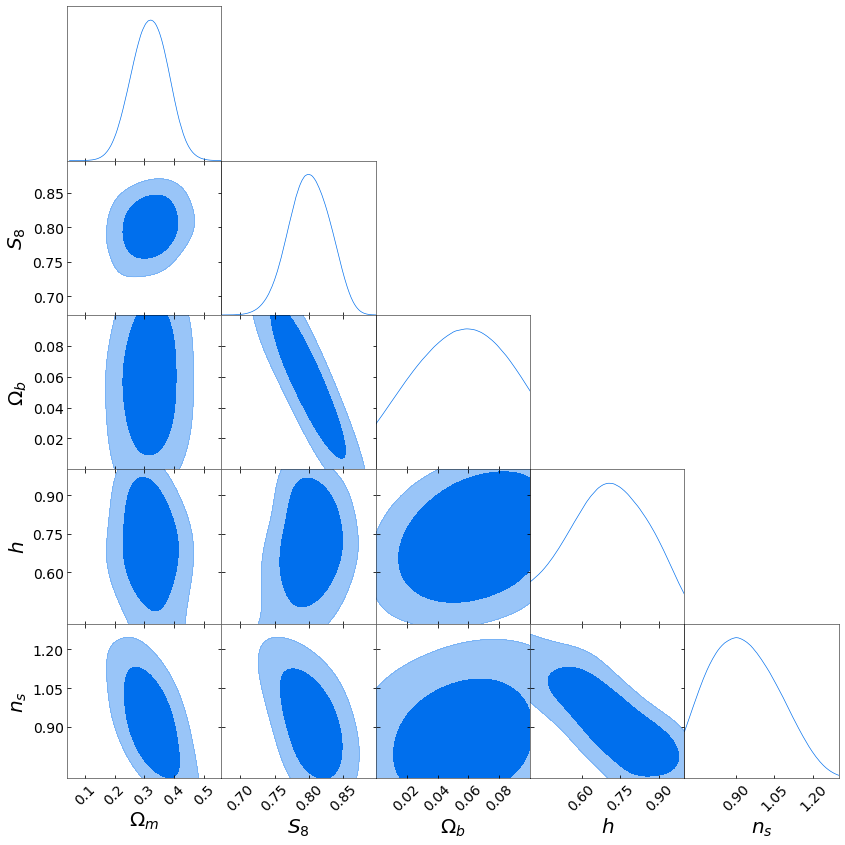

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


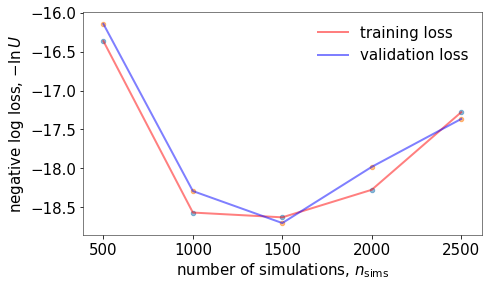

Population 4/23
Sampling proposal density...













Simulations:   0%|          | 0/499 [00:00<?, ?it/s]

Done.
Running 500 sims...













Simulations:   0%|          | 1/499 [00:00<04:47,  1.73it/s]










Simulations:   0%|          | 2/499 [00:01<04:33,  1.82it/s]










Simulations:   1%|          | 3/499 [00:01<04:37,  1.79it/s]










Simulations:   1%|          | 4/499 [00:02<04:38,  1.78it/s]










Simulations:   1%|          | 5/499 [00:02<04:39,  1.76it/s]










Simulations:   1%|          | 6/499 [00:03<04:33,  1.80it/s]










Simulations:   1%|▏         | 7/499 [00:03<04:32,  1.81it/s]










Simulations:   2%|▏         | 8/499 [00:04<04:40,  1.75it/s]










Simulations:   2%|▏         | 9/499 [00:05<04:37,  1.77it/s]










Simulations:   2%|▏         | 10/499 [00:05<04:24,  1.85it/s]










Simulations:   2%|▏         | 11/499 [00:06<04:23,  1.85it/s]










Simulations:   2%|▏         | 12/499 [00:06<04:29,  1.80it/s]










Simulations:   3%|▎         | 13/499 [00:07<04:20,  1.87it/s]










Simulations:   3%|▎         | 14/499 [00:07<04:36,  1.75it/s]


Simulations:  16%|█▌        | 79/499 [00:43<03:25,  2.05it/s]










Simulations:  16%|█▌        | 80/499 [00:44<03:44,  1.87it/s]










Simulations:  16%|█▌        | 81/499 [00:44<03:44,  1.86it/s]










Simulations:  16%|█▋        | 82/499 [00:45<03:50,  1.81it/s]










Simulations:  17%|█▋        | 83/499 [00:45<03:51,  1.80it/s]










Simulations:  17%|█▋        | 84/499 [00:46<03:54,  1.77it/s]










Simulations:  17%|█▋        | 85/499 [00:46<03:43,  1.85it/s]










Simulations:  17%|█▋        | 86/499 [00:47<03:35,  1.92it/s]










Simulations:  17%|█▋        | 87/499 [00:47<03:40,  1.87it/s]










Simulations:  18%|█▊        | 88/499 [00:48<03:37,  1.89it/s]










Simulations:  18%|█▊        | 89/499 [00:48<03:28,  1.96it/s]










Simulations:  18%|█▊        | 90/499 [00:49<03:22,  2.02it/s]










Simulations:  18%|█▊        | 91/499 [00:49<03:23,  2.00it/s]










Simulations:  18%|█▊        | 92/499 [00:50<03:23,  2.00it/s]




Simulations:  31%|███▏      | 156/499 [01:24<03:19,  1.72it/s]










Simulations:  31%|███▏      | 157/499 [01:25<03:23,  1.68it/s]










Simulations:  32%|███▏      | 158/499 [01:26<03:28,  1.64it/s]










Simulations:  32%|███▏      | 159/499 [01:26<03:32,  1.60it/s]










Simulations:  32%|███▏      | 160/499 [01:27<03:31,  1.60it/s]










Simulations:  32%|███▏      | 161/499 [01:27<03:17,  1.71it/s]










Simulations:  32%|███▏      | 162/499 [01:28<03:05,  1.81it/s]










Simulations:  33%|███▎      | 163/499 [01:28<03:15,  1.72it/s]










Simulations:  33%|███▎      | 164/499 [01:29<03:19,  1.68it/s]










Simulations:  33%|███▎      | 165/499 [01:30<03:10,  1.75it/s]










Simulations:  33%|███▎      | 166/499 [01:30<03:00,  1.84it/s]










Simulations:  33%|███▎      | 167/499 [01:31<02:55,  1.89it/s]










Simulations:  34%|███▎      | 168/499 [01:31<02:53,  1.90it/s]










Simulations:  34%|███▍      | 169/499 [01:32<02:51,

Simulator returns exception for parameter values: [0.15396893 0.80716957 0.04127317 0.87362287 1.07105765] (rank 0)













Simulations:  42%|████▏     | 208/499 [01:54<03:09,  1.54it/s]










Simulations:  42%|████▏     | 209/499 [01:55<03:06,  1.56it/s]










Simulations:  42%|████▏     | 210/499 [01:56<02:58,  1.62it/s]










Simulations:  42%|████▏     | 211/499 [01:56<02:52,  1.67it/s]










Simulations:  42%|████▏     | 212/499 [01:57<02:40,  1.79it/s]










Simulations:  43%|████▎     | 213/499 [01:57<02:40,  1.78it/s]










Simulations:  43%|████▎     | 214/499 [01:58<02:41,  1.76it/s]










Simulations:  43%|████▎     | 215/499 [01:58<02:34,  1.83it/s]










Simulations:  43%|████▎     | 216/499 [01:59<02:36,  1.81it/s]










Simulations:  43%|████▎     | 217/499 [01:59<02:41,  1.75it/s]










Simulations:  44%|████▎     | 218/499 [02:00<02:48,  1.67it/s]










Simulations:  44%|████▍     | 219/499 [02:01<02:46,  1.68it/s]










Simulations:  44%|████▍     | 220/499 [02:01<02:48,  1.66it/s]










Simulations:  44%|████▍     | 221/499 [0

Simulator returns exception for parameter values: [0.16746577 0.72371087 0.07012781 0.59697268 1.20683326] (rank 0)
Simulator returns exception for parameter values: [0.11676988 0.70030304 0.07756835 0.57590465 1.28719862] (rank 0)
Simulator returns exception for parameter values: [0.11676988 0.70030304 0.07756835 0.57590465 1.28719862] (rank 0)
Simulator returns exception for parameter values: [0.11676988 0.70030304 0.07756835 0.57590465 1.28719862] (rank 0)
Simulator returns exception for parameter values: [0.11676988 0.70030304 0.07756835 0.57590465 1.28719862] (rank 0)
Simulator returns exception for parameter values: [0.11676988 0.70030304 0.07756835 0.57590465 1.28719862] (rank 0)
Simulator returns exception for parameter values: [0.12502104 0.70669996 0.07408158 0.56743164 1.28315639] (rank 0)
Simulator returns exception for parameter values: [0.13787793 0.71802323 0.0699029  0.57076077 1.26703768] (rank 0)
Simulator returns exception for parameter values: [0.15425375 0.72759066












Simulations:  44%|████▍     | 222/499 [02:04<05:13,  1.13s/it]










Simulations:  45%|████▍     | 223/499 [02:05<04:22,  1.05it/s]










Simulations:  45%|████▍     | 224/499 [02:05<03:50,  1.19it/s]










Simulations:  45%|████▌     | 225/499 [02:06<03:31,  1.30it/s]










Simulations:  45%|████▌     | 226/499 [02:07<03:09,  1.44it/s]










Simulations:  45%|████▌     | 227/499 [02:07<02:49,  1.61it/s]










Simulations:  46%|████▌     | 228/499 [02:07<02:36,  1.73it/s]










Simulations:  46%|████▌     | 229/499 [02:08<02:39,  1.69it/s]










Simulations:  46%|████▌     | 230/499 [02:09<02:41,  1.67it/s]










Simulations:  46%|████▋     | 231/499 [02:09<02:43,  1.63it/s]










Simulations:  46%|████▋     | 232/499 [02:10<02:45,  1.62it/s]










Simulations:  47%|████▋     | 233/499 [02:11<02:39,  1.67it/s]










Simulations:  47%|████▋     | 234/499 [02:11<02:43,  1.62it/s]










Simulations:  47%|████▋     | 235/499 [0

Simulator returns exception for parameter values: [0.14390606 0.7709451  0.05681521 0.82239152 1.28338463] (rank 0)
Simulator returns exception for parameter values: [0.14390606 0.7709451  0.05681521 0.82239152 1.28338463] (rank 0)
Simulator returns exception for parameter values: [0.14526952 0.77140554 0.05649    0.82097873 1.28018086] (rank 0)













Simulations:  54%|█████▎    | 268/499 [02:30<02:23,  1.61it/s]










Simulations:  54%|█████▍    | 269/499 [02:30<02:19,  1.65it/s]










Simulations:  54%|█████▍    | 270/499 [02:31<02:16,  1.68it/s]










Simulations:  54%|█████▍    | 271/499 [02:31<02:06,  1.80it/s]










Simulations:  55%|█████▍    | 272/499 [02:32<02:00,  1.89it/s]










Simulations:  55%|█████▍    | 273/499 [02:32<01:57,  1.92it/s]










Simulations:  55%|█████▍    | 274/499 [02:33<01:55,  1.94it/s]










Simulations:  55%|█████▌    | 275/499 [02:33<01:55,  1.94it/s]










Simulations:  55%|█████▌    | 276/499 [02:34<01:53,  1.96it/s]










Simulations:  56%|█████▌    | 277/499 [02:35<01:56,  1.90it/s]










Simulations:  56%|█████▌    | 278/499 [02:35<02:08,  1.73it/s]










Simulations:  56%|█████▌    | 279/499 [02:36<02:09,  1.70it/s]










Simulations:  56%|█████▌    | 280/499 [02:36<02:07,  1.72it/s]










Simulations:  56%|█████▋    | 281/499 [0

Simulator returns exception for parameter values: [0.17923311 0.74751527 0.08706699 0.77873857 1.11732277] (rank 0)
Simulator returns exception for parameter values: [0.17923311 0.74751527 0.08706699 0.77873857 1.11732277] (rank 0)
Simulator returns exception for parameter values: [0.17923311 0.74751527 0.08706699 0.77873857 1.11732277] (rank 0)













Simulations:  62%|██████▏   | 308/499 [02:53<02:18,  1.38it/s]










Simulations:  62%|██████▏   | 309/499 [02:54<02:10,  1.46it/s]










Simulations:  62%|██████▏   | 310/499 [02:54<02:04,  1.51it/s]










Simulations:  62%|██████▏   | 311/499 [02:55<02:03,  1.53it/s]










Simulations:  63%|██████▎   | 312/499 [02:55<01:57,  1.59it/s]










Simulations:  63%|██████▎   | 313/499 [02:56<01:51,  1.67it/s]










Simulations:  63%|██████▎   | 314/499 [02:56<01:42,  1.80it/s]










Simulations:  63%|██████▎   | 315/499 [02:57<01:37,  1.89it/s]










Simulations:  63%|██████▎   | 316/499 [02:57<01:32,  1.98it/s]










Simulations:  64%|██████▎   | 317/499 [02:58<01:37,  1.87it/s]










Simulations:  64%|██████▎   | 318/499 [02:59<01:40,  1.80it/s]










Simulations:  64%|██████▍   | 319/499 [02:59<01:45,  1.70it/s]










Simulations:  64%|██████▍   | 320/499 [03:00<01:44,  1.71it/s]










Simulations:  64%|██████▍   | 321/499 [0

Simulator returns exception for parameter values: [0.14106757 0.73938965 0.07430306 0.94409708 1.02933091] (rank 0)
Simulator returns exception for parameter values: [0.13164124 0.73819698 0.07396546 0.9501979  1.03766946] (rank 0)
Simulator returns exception for parameter values: [0.12297005 0.73779559 0.07434896 0.97469066 1.03511212] (rank 0)
Simulator returns exception for parameter values: [0.12297005 0.73779559 0.07434896 0.97469066 1.03511212] (rank 0)
Simulator returns exception for parameter values: [0.12297005 0.73779559 0.07434896 0.97469066 1.03511212] (rank 0)
Simulator returns exception for parameter values: [0.12297005 0.73779559 0.07434896 0.97469066 1.03511212] (rank 0)
Simulator returns exception for parameter values: [0.17503002 0.7516526  0.06778601 0.85793719 1.04116351] (rank 0)
Simulator returns exception for parameter values: [0.17503002 0.7516526  0.06778601 0.85793719 1.04116351] (rank 0)
Simulator returns exception for parameter values: [0.17503002 0.7516526 












Simulations:  67%|██████▋   | 333/499 [03:09<03:23,  1.23s/it]










Simulations:  67%|██████▋   | 334/499 [03:10<02:51,  1.04s/it]










Simulations:  67%|██████▋   | 335/499 [03:10<02:22,  1.15it/s]










Simulations:  67%|██████▋   | 336/499 [03:11<02:06,  1.28it/s]










Simulations:  68%|██████▊   | 337/499 [03:11<01:54,  1.42it/s]










Simulations:  68%|██████▊   | 338/499 [03:12<01:44,  1.54it/s]










Simulations:  68%|██████▊   | 339/499 [03:12<01:36,  1.65it/s]










Simulations:  68%|██████▊   | 340/499 [03:13<01:37,  1.63it/s]










Simulations:  68%|██████▊   | 341/499 [03:13<01:29,  1.76it/s]










Simulations:  69%|██████▊   | 342/499 [03:14<01:21,  1.93it/s]










Simulations:  69%|██████▊   | 343/499 [03:14<01:20,  1.94it/s]










Simulations:  69%|██████▉   | 344/499 [03:15<01:22,  1.87it/s]










Simulations:  69%|██████▉   | 345/499 [03:15<01:22,  1.87it/s]










Simulations:  69%|██████▉   | 346/499 [0

Simulator returns exception for parameter values: [0.1418945  0.78283376 0.01377199 0.63213562 1.2100337 ] (rank 0)
Simulator returns exception for parameter values: [0.1418945  0.78283376 0.01377199 0.63213562 1.2100337 ] (rank 0)













Simulations:  71%|███████   | 353/499 [03:20<01:35,  1.52it/s]










Simulations:  71%|███████   | 354/499 [03:21<01:30,  1.60it/s]










Simulations:  71%|███████   | 355/499 [03:21<01:25,  1.68it/s]










Simulations:  71%|███████▏  | 356/499 [03:22<01:19,  1.79it/s]










Simulations:  72%|███████▏  | 357/499 [03:22<01:15,  1.88it/s]










Simulations:  72%|███████▏  | 358/499 [03:23<01:16,  1.85it/s]










Simulations:  72%|███████▏  | 359/499 [03:23<01:16,  1.83it/s]










Simulations:  72%|███████▏  | 360/499 [03:24<01:19,  1.76it/s]










Simulations:  72%|███████▏  | 361/499 [03:24<01:20,  1.71it/s]










Simulations:  73%|███████▎  | 362/499 [03:25<01:16,  1.80it/s]










Simulations:  73%|███████▎  | 363/499 [03:25<01:14,  1.81it/s]










Simulations:  73%|███████▎  | 364/499 [03:26<01:19,  1.71it/s]










Simulations:  73%|███████▎  | 365/499 [03:27<01:26,  1.55it/s]










Simulations:  73%|███████▎  | 366/499 [0

Simulations:  86%|████████▌ | 430/499 [04:04<00:35,  1.95it/s]










Simulations:  86%|████████▋ | 431/499 [04:04<00:33,  2.01it/s]










Simulations:  87%|████████▋ | 432/499 [04:04<00:32,  2.07it/s]










Simulations:  87%|████████▋ | 433/499 [04:05<00:33,  2.00it/s]










Simulations:  87%|████████▋ | 434/499 [04:05<00:32,  2.01it/s]










Simulations:  87%|████████▋ | 435/499 [04:06<00:30,  2.07it/s]










Simulations:  87%|████████▋ | 436/499 [04:07<00:32,  1.91it/s]










Simulations:  88%|████████▊ | 437/499 [04:07<00:32,  1.91it/s]

Simulator returns exception for parameter values: [0.15860771 0.83272172 0.01588243 0.55676242 1.24201185] (rank 0)
Simulator returns exception for parameter values: [0.15860771 0.83272172 0.01588243 0.55676242 1.24201185] (rank 0)
Simulator returns exception for parameter values: [0.15860771 0.83272172 0.01588243 0.55676242 1.24201185] (rank 0)
Simulator returns exception for parameter values: [0.15860771 0.83272172 0.01588243 0.55676242 1.24201185] (rank 0)













Simulations:  88%|████████▊ | 438/499 [04:08<00:42,  1.43it/s]










Simulations:  88%|████████▊ | 439/499 [04:09<00:39,  1.53it/s]










Simulations:  88%|████████▊ | 440/499 [04:09<00:36,  1.61it/s]










Simulations:  88%|████████▊ | 441/499 [04:10<00:34,  1.67it/s]










Simulations:  89%|████████▊ | 442/499 [04:10<00:32,  1.77it/s]










Simulations:  89%|████████▉ | 443/499 [04:11<00:29,  1.87it/s]










Simulations:  89%|████████▉ | 444/499 [04:11<00:28,  1.96it/s]










Simulations:  89%|████████▉ | 445/499 [04:12<00:27,  2.00it/s]










Simulations:  89%|████████▉ | 446/499 [04:12<00:27,  1.94it/s]










Simulations:  90%|████████▉ | 447/499 [04:13<00:27,  1.89it/s]










Simulations:  90%|████████▉ | 448/499 [04:13<00:28,  1.76it/s]










Simulations:  90%|████████▉ | 449/499 [04:14<00:28,  1.74it/s]










Simulations:  90%|█████████ | 450/499 [04:15<00:28,  1.74it/s]










Simulations:  90%|█████████ | 451/499 [0

Simulator returns exception for parameter values: [0.16490661 0.78719521 0.06665698 0.88473579 1.03242575] (rank 0)













Simulations:  91%|█████████ | 452/499 [04:16<00:29,  1.59it/s]










Simulations:  91%|█████████ | 453/499 [04:17<00:27,  1.65it/s]










Simulations:  91%|█████████ | 454/499 [04:17<00:25,  1.78it/s]










Simulations:  91%|█████████ | 455/499 [04:17<00:23,  1.91it/s]










Simulations:  91%|█████████▏| 456/499 [04:18<00:23,  1.86it/s]










Simulations:  92%|█████████▏| 457/499 [04:19<00:22,  1.84it/s]










Simulations:  92%|█████████▏| 458/499 [04:19<00:23,  1.76it/s]










Simulations:  92%|█████████▏| 459/499 [04:20<00:23,  1.68it/s]










Simulations:  92%|█████████▏| 460/499 [04:20<00:21,  1.80it/s]










Simulations:  92%|█████████▏| 461/499 [04:21<00:19,  1.91it/s]










Simulations:  93%|█████████▎| 462/499 [04:21<00:19,  1.86it/s]










Simulations:  93%|█████████▎| 463/499 [04:22<00:19,  1.81it/s]










Simulations:  93%|█████████▎| 464/499 [04:22<00:19,  1.80it/s]










Simulations:  93%|█████████▎| 465/499 [0

Done.














Epochs:   1%|          | 1/100 [00:00<00:23,  4.16it/s, train_loss=-18.6, val_loss=-18.8]











Epochs:   1%|          | 1/100 [00:00<00:23,  4.16it/s, train_loss=-18.6, val_loss=-18.7]











Epochs:   2%|▏         | 2/100 [00:00<00:19,  4.98it/s, train_loss=-18.6, val_loss=-18.7]











Epochs:   2%|▏         | 2/100 [00:00<00:19,  4.98it/s, train_loss=-18.7, val_loss=-18.8]











Epochs:   3%|▎         | 3/100 [00:00<00:17,  5.70it/s, train_loss=-18.7, val_loss=-18.8]











Epochs:   3%|▎         | 3/100 [00:00<00:17,  5.70it/s, train_loss=-18.9, val_loss=-18.9]











Epochs:   4%|▍         | 4/100 [00:00<00:17,  5.38it/s, train_loss=-18.9, val_loss=-18.9]











Epochs:   4%|▍         | 4/100 [00:00<00:17,  5.38it/s, train_loss=-18, val_loss=-18.1]  











Epochs:   5%|▌         | 5/100 [00:00<00:15,  6.06it/s, train_loss=-18, val_loss=-18.1]











Epochs:   5%|▌         | 5/100 [00:00<00:15,  6.06it/s, train_loss=-18.9, val_los

Training finished
Best epoch 00028, Val_loss: -19.1124
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...
Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving simulators/cosmic_shear/results/seq_train_post_4.pdf


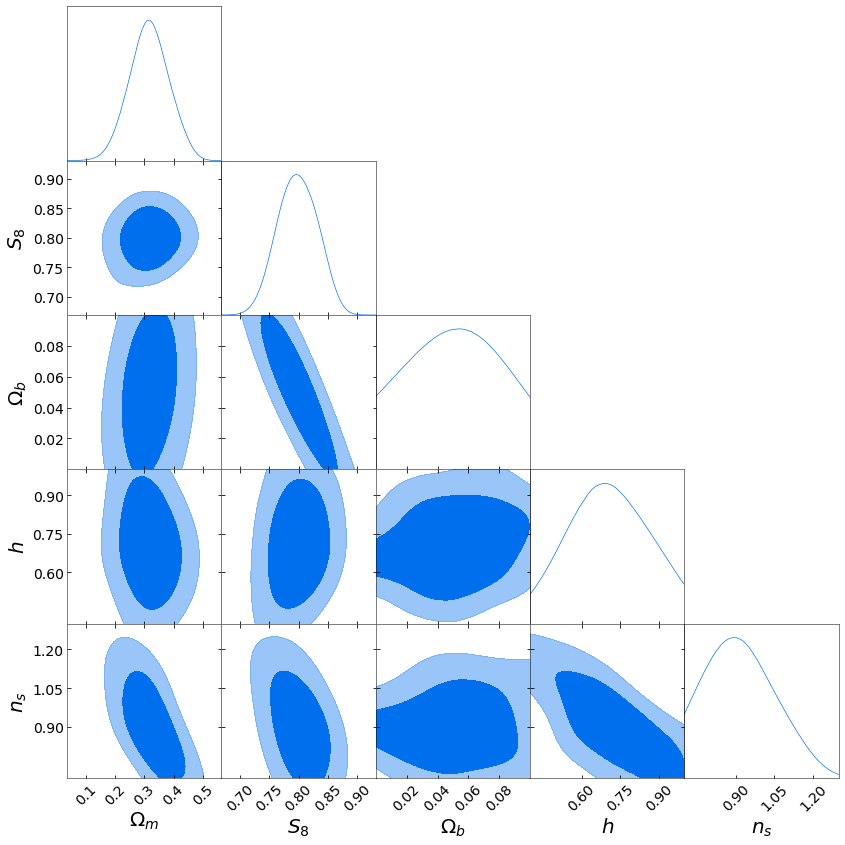

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


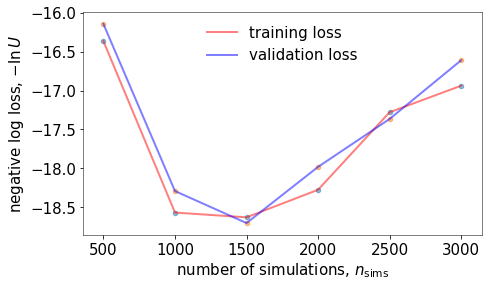

Population 5/23
Sampling proposal density...















Simulations:   0%|          | 0/499 [00:00<?, ?it/s]

Done.
Running 500 sims...















Simulations:   0%|          | 1/499 [00:00<04:40,  1.77it/s]












Simulations:   0%|          | 2/499 [00:01<04:29,  1.84it/s]












Simulations:   1%|          | 3/499 [00:01<04:29,  1.84it/s]












Simulations:   1%|          | 4/499 [00:02<04:17,  1.92it/s]












Simulations:   1%|          | 5/499 [00:02<04:05,  2.01it/s]












Simulations:   1%|          | 6/499 [00:02<04:00,  2.05it/s]












Simulations:   1%|▏         | 7/499 [00:03<03:53,  2.11it/s]












Simulations:   2%|▏         | 8/499 [00:04<04:10,  1.96it/s]












Simulations:   2%|▏         | 9/499 [00:04<04:05,  1.99it/s]












Simulations:   2%|▏         | 10/499 [00:05<04:15,  1.92it/s]












Simulations:   2%|▏         | 11/499 [00:05<04:40,  1.74it/s]












Simulations:   2%|▏         | 12/499 [00:06<05:03,  1.60it/s]












Simulations:   3%|▎         | 13/499 [00:07<04:51,  1.67it/s]












Simulations:   3%|▎         | 14/4

Simulations:  15%|█▍        | 73/499 [00:40<04:22,  1.62it/s]












Simulations:  15%|█▍        | 74/499 [00:40<04:25,  1.60it/s]












Simulations:  15%|█▌        | 75/499 [00:41<04:23,  1.61it/s]












Simulations:  15%|█▌        | 76/499 [00:41<04:25,  1.59it/s]












Simulations:  15%|█▌        | 77/499 [00:42<04:14,  1.65it/s]












Simulations:  16%|█▌        | 78/499 [00:43<04:15,  1.65it/s]












Simulations:  16%|█▌        | 79/499 [00:43<04:08,  1.69it/s]












Simulations:  16%|█▌        | 80/499 [00:44<04:12,  1.66it/s]












Simulations:  16%|█▌        | 81/499 [00:44<03:59,  1.75it/s]












Simulations:  16%|█▋        | 82/499 [00:45<03:49,  1.81it/s]












Simulations:  17%|█▋        | 83/499 [00:45<03:48,  1.82it/s]












Simulations:  17%|█▋        | 84/499 [00:46<04:03,  1.71it/s]












Simulations:  17%|█▋        | 85/499 [00:46<03:51,  1.79it/s]












Simulations:  17%|█▋        | 86/499 [

Simulations:  29%|██▉       | 145/499 [01:20<03:00,  1.97it/s]












Simulations:  29%|██▉       | 146/499 [01:21<02:58,  1.98it/s]












Simulations:  29%|██▉       | 147/499 [01:21<02:59,  1.96it/s]












Simulations:  30%|██▉       | 148/499 [01:22<02:52,  2.04it/s]












Simulations:  30%|██▉       | 149/499 [01:22<03:09,  1.85it/s]












Simulations:  30%|███       | 150/499 [01:23<03:16,  1.78it/s]












Simulations:  30%|███       | 151/499 [01:23<03:14,  1.79it/s]












Simulations:  30%|███       | 152/499 [01:24<03:16,  1.76it/s]












Simulations:  31%|███       | 153/499 [01:25<03:03,  1.88it/s]












Simulations:  31%|███       | 154/499 [01:25<03:03,  1.88it/s]












Simulations:  31%|███       | 155/499 [01:26<03:05,  1.85it/s]












Simulations:  31%|███▏      | 156/499 [01:26<02:57,  1.93it/s]












Simulations:  31%|███▏      | 157/499 [01:27<02:55,  1.95it/s]












Simulations:  32%|███▏   

Simulations:  43%|████▎     | 216/499 [02:01<02:49,  1.66it/s]












Simulations:  43%|████▎     | 217/499 [02:01<02:37,  1.79it/s]












Simulations:  44%|████▎     | 218/499 [02:02<02:29,  1.88it/s]












Simulations:  44%|████▍     | 219/499 [02:02<02:29,  1.87it/s]












Simulations:  44%|████▍     | 220/499 [02:03<02:39,  1.75it/s]












Simulations:  44%|████▍     | 221/499 [02:04<02:40,  1.73it/s]












Simulations:  44%|████▍     | 222/499 [02:04<02:44,  1.68it/s]












Simulations:  45%|████▍     | 223/499 [02:05<02:47,  1.64it/s]












Simulations:  45%|████▍     | 224/499 [02:05<02:39,  1.72it/s]












Simulations:  45%|████▌     | 225/499 [02:06<02:44,  1.66it/s]












Simulations:  45%|████▌     | 226/499 [02:07<02:39,  1.72it/s]












Simulations:  45%|████▌     | 227/499 [02:07<02:31,  1.80it/s]












Simulations:  46%|████▌     | 228/499 [02:08<02:35,  1.74it/s]












Simulations:  46%|████▌  

Simulations:  58%|█████▊    | 287/499 [02:41<02:07,  1.66it/s]












Simulations:  58%|█████▊    | 288/499 [02:42<02:05,  1.68it/s]












Simulations:  58%|█████▊    | 289/499 [02:43<01:59,  1.76it/s]












Simulations:  58%|█████▊    | 290/499 [02:43<02:00,  1.74it/s]












Simulations:  58%|█████▊    | 291/499 [02:44<01:57,  1.77it/s]












Simulations:  59%|█████▊    | 292/499 [02:44<01:52,  1.84it/s]












Simulations:  59%|█████▊    | 293/499 [02:45<01:51,  1.85it/s]












Simulations:  59%|█████▉    | 294/499 [02:45<01:48,  1.89it/s]












Simulations:  59%|█████▉    | 295/499 [02:46<01:43,  1.96it/s]












Simulations:  59%|█████▉    | 296/499 [02:46<01:43,  1.97it/s]












Simulations:  60%|█████▉    | 297/499 [02:47<01:41,  1.98it/s]












Simulations:  60%|█████▉    | 298/499 [02:47<01:41,  1.99it/s]












Simulations:  60%|█████▉    | 299/499 [02:48<01:49,  1.82it/s]












Simulations:  60%|██████ 

Simulations:  72%|███████▏  | 358/499 [03:20<01:19,  1.77it/s]












Simulations:  72%|███████▏  | 359/499 [03:21<01:16,  1.83it/s]












Simulations:  72%|███████▏  | 360/499 [03:21<01:16,  1.81it/s]












Simulations:  72%|███████▏  | 361/499 [03:22<01:13,  1.88it/s]












Simulations:  73%|███████▎  | 362/499 [03:22<01:10,  1.95it/s]












Simulations:  73%|███████▎  | 363/499 [03:23<01:07,  2.02it/s]












Simulations:  73%|███████▎  | 364/499 [03:23<01:05,  2.07it/s]












Simulations:  73%|███████▎  | 365/499 [03:24<01:10,  1.90it/s]












Simulations:  73%|███████▎  | 366/499 [03:24<01:10,  1.88it/s]












Simulations:  74%|███████▎  | 367/499 [03:25<01:12,  1.83it/s]












Simulations:  74%|███████▎  | 368/499 [03:25<01:13,  1.79it/s]












Simulations:  74%|███████▍  | 369/499 [03:26<01:08,  1.88it/s]












Simulations:  74%|███████▍  | 370/499 [03:26<01:12,  1.79it/s]












Simulations:  74%|███████

Simulations:  86%|████████▌ | 429/499 [04:01<00:40,  1.73it/s]












Simulations:  86%|████████▌ | 430/499 [04:01<00:41,  1.68it/s]












Simulations:  86%|████████▋ | 431/499 [04:02<00:41,  1.64it/s]












Simulations:  87%|████████▋ | 432/499 [04:03<00:39,  1.70it/s]












Simulations:  87%|████████▋ | 433/499 [04:03<00:40,  1.63it/s]












Simulations:  87%|████████▋ | 434/499 [04:04<00:40,  1.60it/s]












Simulations:  87%|████████▋ | 435/499 [04:05<00:38,  1.67it/s]












Simulations:  87%|████████▋ | 436/499 [04:05<00:36,  1.71it/s]












Simulations:  88%|████████▊ | 437/499 [04:06<00:34,  1.77it/s]












Simulations:  88%|████████▊ | 438/499 [04:06<00:33,  1.82it/s]












Simulations:  88%|████████▊ | 439/499 [04:07<00:35,  1.71it/s]












Simulations:  88%|████████▊ | 440/499 [04:07<00:35,  1.67it/s]












Simulations:  88%|████████▊ | 441/499 [04:08<00:36,  1.58it/s]












Simulations:  89%|███████

Simulator returns exception for parameter values: [0.13242177 0.79082343 0.08344938 0.88212794 1.25150224] (rank 0)















Simulations:  97%|█████████▋| 483/499 [04:31<00:08,  1.78it/s]












Simulations:  97%|█████████▋| 484/499 [04:32<00:08,  1.76it/s]












Simulations:  97%|█████████▋| 485/499 [04:32<00:07,  1.78it/s]












Simulations:  97%|█████████▋| 486/499 [04:33<00:07,  1.83it/s]












Simulations:  98%|█████████▊| 487/499 [04:33<00:06,  1.90it/s]












Simulations:  98%|█████████▊| 488/499 [04:34<00:05,  1.95it/s]












Simulations:  98%|█████████▊| 489/499 [04:34<00:05,  1.86it/s]












Simulations:  98%|█████████▊| 490/499 [04:35<00:05,  1.78it/s]












Simulations:  98%|█████████▊| 491/499 [04:36<00:04,  1.70it/s]












Simulations:  99%|█████████▊| 492/499 [04:36<00:04,  1.68it/s]












Simulations:  99%|█████████▉| 493/499 [04:37<00:03,  1.76it/s]












Simulations:  99%|█████████▉| 494/499 [04:37<00:02,  1.71it/s]












Simulations:  99%|█████████▉| 495/499 [04:38<00:02,  1.73it/s]












Simulations:

Done.
















Epochs:   0%|          | 0/100 [00:00<?, ?it/s, train_loss=-17.8, val_loss=-18.1]













Epochs:   1%|          | 1/100 [00:00<00:27,  3.64it/s, train_loss=-17.8, val_loss=-18.1]













Epochs:   1%|          | 1/100 [00:00<00:27,  3.64it/s, train_loss=-18.7, val_loss=-18.9]













Epochs:   2%|▏         | 2/100 [00:00<00:25,  3.87it/s, train_loss=-18.7, val_loss=-18.9]













Epochs:   2%|▏         | 2/100 [00:00<00:25,  3.87it/s, train_loss=-18.9, val_loss=-19.1]













Epochs:   3%|▎         | 3/100 [00:00<00:22,  4.23it/s, train_loss=-18.9, val_loss=-19.1]













Epochs:   3%|▎         | 3/100 [00:00<00:22,  4.23it/s, train_loss=-18.9, val_loss=-19.1]













Epochs:   4%|▍         | 4/100 [00:00<00:22,  4.27it/s, train_loss=-18.9, val_loss=-19.1]













Epochs:   4%|▍         | 4/100 [00:01<00:22,  4.27it/s, train_loss=-19, val_loss=-19.2]  













Epochs:   5%|▌         | 5/100 [00:01<00:21,  4.38it/s, train_loss=

Training finished
Best epoch 00021, Val_loss: -19.3862
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...
Done.
Removed no burn in


/home/tomcharnock/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Saving simulators/cosmic_shear/results/seq_train_post_5.pdf


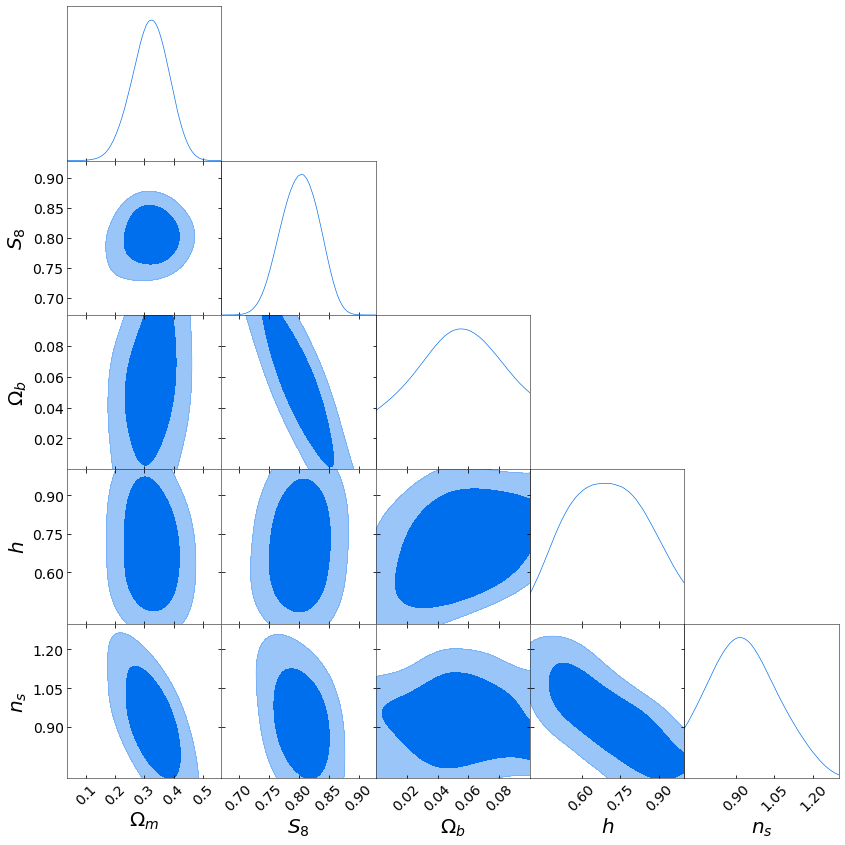

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


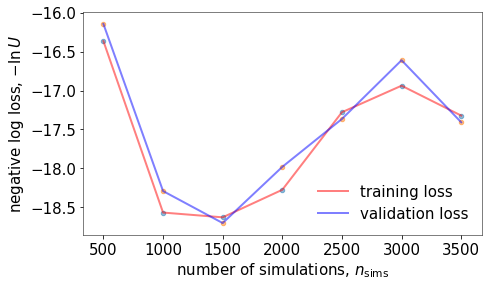

Population 6/23
Sampling proposal density...

















Simulations:   0%|          | 0/499 [00:00<?, ?it/s]

Done.
Running 500 sims...

















Simulations:   0%|          | 1/499 [00:00<05:17,  1.57it/s]














Simulations:   0%|          | 2/499 [00:01<05:01,  1.65it/s]














Simulations:   1%|          | 3/499 [00:01<04:43,  1.75it/s]














Simulations:   1%|          | 4/499 [00:02<04:47,  1.72it/s]














Simulations:   1%|          | 5/499 [00:02<04:56,  1.67it/s]














Simulations:   1%|          | 6/499 [00:03<05:07,  1.60it/s]














Simulations:   1%|▏         | 7/499 [00:04<05:12,  1.57it/s]














Simulations:   2%|▏         | 8/499 [00:04<05:14,  1.56it/s]














Simulations:   2%|▏         | 9/499 [00:05<05:19,  1.54it/s]














Simulations:   2%|▏         | 10/499 [00:06<05:11,  1.57it/s]














Simulations:   2%|▏         | 11/499 [00:06<05:12,  1.56it/s]














Simulations:   2%|▏         | 12/499 [00:07<05:03,  1.60it/s]














Simulations:   3%|▎         | 13/499 [00:08<05:09,  1.57it/s]














Simula

Simulations:  14%|█▎        | 68/499 [00:40<03:53,  1.85it/s]














Simulations:  14%|█▍        | 69/499 [00:40<03:43,  1.92it/s]














Simulations:  14%|█▍        | 70/499 [00:40<03:39,  1.96it/s]














Simulations:  14%|█▍        | 71/499 [00:41<03:31,  2.02it/s]














Simulations:  14%|█▍        | 72/499 [00:42<03:51,  1.85it/s]














Simulations:  15%|█▍        | 73/499 [00:42<03:49,  1.86it/s]














Simulations:  15%|█▍        | 74/499 [00:43<03:46,  1.87it/s]














Simulations:  15%|█▌        | 75/499 [00:43<03:57,  1.79it/s]














Simulations:  15%|█▌        | 76/499 [00:44<03:48,  1.85it/s]














Simulations:  15%|█▌        | 77/499 [00:44<03:37,  1.94it/s]














Simulations:  16%|█▌        | 78/499 [00:45<03:39,  1.92it/s]














Simulations:  16%|█▌        | 79/499 [00:45<03:49,  1.83it/s]














Simulations:  16%|█▌        | 80/499 [00:46<03:43,  1.87it/s]














Simulations:

Simulations:  27%|██▋       | 135/499 [01:16<03:20,  1.82it/s]














Simulations:  27%|██▋       | 136/499 [01:16<03:34,  1.69it/s]














Simulations:  27%|██▋       | 137/499 [01:17<03:30,  1.72it/s]














Simulations:  28%|██▊       | 138/499 [01:18<03:34,  1.68it/s]














Simulations:  28%|██▊       | 139/499 [01:18<03:32,  1.69it/s]














Simulations:  28%|██▊       | 140/499 [01:19<03:32,  1.69it/s]














Simulations:  28%|██▊       | 141/499 [01:19<03:32,  1.69it/s]














Simulations:  28%|██▊       | 142/499 [01:20<03:18,  1.80it/s]














Simulations:  29%|██▊       | 143/499 [01:20<03:12,  1.84it/s]














Simulations:  29%|██▉       | 144/499 [01:21<03:07,  1.89it/s]














Simulations:  29%|██▉       | 145/499 [01:21<03:02,  1.94it/s]














Simulations:  29%|██▉       | 146/499 [01:22<03:09,  1.86it/s]














Simulations:  29%|██▉       | 147/499 [01:23<03:13,  1.82it/s]















Simulations:  40%|████      | 202/499 [01:53<02:39,  1.86it/s]














Simulations:  41%|████      | 203/499 [01:54<02:31,  1.95it/s]














Simulations:  41%|████      | 204/499 [01:54<02:27,  1.99it/s]














Simulations:  41%|████      | 205/499 [01:54<02:21,  2.07it/s]














Simulations:  41%|████▏     | 206/499 [01:55<02:21,  2.06it/s]














Simulations:  41%|████▏     | 207/499 [01:55<02:14,  2.17it/s]














Simulations:  42%|████▏     | 208/499 [01:56<02:12,  2.20it/s]














Simulations:  42%|████▏     | 209/499 [01:56<02:12,  2.19it/s]














Simulations:  42%|████▏     | 210/499 [01:57<02:14,  2.15it/s]














Simulations:  42%|████▏     | 211/499 [01:57<02:15,  2.13it/s]














Simulations:  42%|████▏     | 212/499 [01:58<02:12,  2.17it/s]














Simulations:  43%|████▎     | 213/499 [01:58<02:12,  2.16it/s]














Simulations:  43%|████▎     | 214/499 [01:59<02:13,  2.14it/s]















Simulations:  54%|█████▍    | 269/499 [02:28<01:59,  1.93it/s]














Simulations:  54%|█████▍    | 270/499 [02:29<02:06,  1.82it/s]














Simulations:  54%|█████▍    | 271/499 [02:29<02:09,  1.76it/s]














Simulations:  55%|█████▍    | 272/499 [02:30<02:11,  1.73it/s]














Simulations:  55%|█████▍    | 273/499 [02:31<02:12,  1.70it/s]














Simulations:  55%|█████▍    | 274/499 [02:31<02:10,  1.73it/s]














Simulations:  55%|█████▌    | 275/499 [02:32<02:02,  1.83it/s]














Simulations:  55%|█████▌    | 276/499 [02:32<01:57,  1.90it/s]














Simulations:  56%|█████▌    | 277/499 [02:33<01:54,  1.94it/s]














Simulations:  56%|█████▌    | 278/499 [02:33<01:59,  1.85it/s]














Simulations:  56%|█████▌    | 279/499 [02:34<02:02,  1.80it/s]














Simulations:  56%|█████▌    | 280/499 [02:34<02:01,  1.80it/s]














Simulations:  56%|█████▋    | 281/499 [02:35<02:00,  1.81it/s]















Simulator returns exception for parameter values: [0.12365069 0.75083318 0.06620467 0.72830523 1.20600992] (rank 0)
Simulator returns exception for parameter values: [0.13850298 0.76296242 0.06342512 0.73573643 1.20765145] (rank 0)

















Simulations:  58%|█████▊    | 290/499 [02:39<02:00,  1.74it/s]














Simulations:  58%|█████▊    | 291/499 [02:40<01:51,  1.86it/s]














Simulations:  59%|█████▊    | 292/499 [02:40<01:46,  1.95it/s]














Simulations:  59%|█████▊    | 293/499 [02:41<01:43,  1.98it/s]














Simulations:  59%|█████▉    | 294/499 [02:41<01:47,  1.91it/s]














Simulations:  59%|█████▉    | 295/499 [02:42<01:46,  1.92it/s]














Simulations:  59%|█████▉    | 296/499 [02:42<01:45,  1.92it/s]














Simulations:  60%|█████▉    | 297/499 [02:43<01:45,  1.91it/s]














Simulations:  60%|█████▉    | 298/499 [02:44<01:51,  1.80it/s]














Simulations:  60%|█████▉    | 299/499 [02:44<01:50,  1.80it/s]














Simulations:  60%|██████    | 300/499 [02:45<01:59,  1.67it/s]














Simulations:  60%|██████    | 301/499 [02:45<01:58,  1.66it/s]














Simulations:  61%|██████    | 302/499 [02:46<02:01,  1.63it/s

Simulations:  72%|███████▏  | 357/499 [03:20<01:29,  1.59it/s]














Simulations:  72%|███████▏  | 358/499 [03:21<01:30,  1.56it/s]














Simulations:  72%|███████▏  | 359/499 [03:22<01:27,  1.60it/s]














Simulations:  72%|███████▏  | 360/499 [03:22<01:24,  1.64it/s]














Simulations:  72%|███████▏  | 361/499 [03:23<01:26,  1.60it/s]














Simulations:  73%|███████▎  | 362/499 [03:24<01:25,  1.60it/s]














Simulations:  73%|███████▎  | 363/499 [03:24<01:20,  1.68it/s]














Simulations:  73%|███████▎  | 364/499 [03:25<01:17,  1.74it/s]














Simulations:  73%|███████▎  | 365/499 [03:25<01:20,  1.66it/s]














Simulations:  73%|███████▎  | 366/499 [03:26<01:20,  1.66it/s]














Simulations:  74%|███████▎  | 367/499 [03:26<01:16,  1.73it/s]














Simulations:  74%|███████▎  | 368/499 [03:27<01:13,  1.78it/s]














Simulations:  74%|███████▍  | 369/499 [03:27<01:11,  1.83it/s]















Simulations:  85%|████████▍ | 424/499 [03:59<00:40,  1.85it/s]














Simulations:  85%|████████▌ | 425/499 [03:59<00:39,  1.86it/s]














Simulations:  85%|████████▌ | 426/499 [04:00<00:40,  1.81it/s]














Simulations:  86%|████████▌ | 427/499 [04:01<00:38,  1.87it/s]














Simulations:  86%|████████▌ | 428/499 [04:01<00:36,  1.93it/s]














Simulations:  86%|████████▌ | 429/499 [04:01<00:34,  2.01it/s]














Simulations:  86%|████████▌ | 430/499 [04:02<00:34,  2.03it/s]














Simulations:  86%|████████▋ | 431/499 [04:02<00:32,  2.06it/s]














Simulations:  87%|████████▋ | 432/499 [04:03<00:32,  2.09it/s]














Simulations:  87%|████████▋ | 433/499 [04:03<00:32,  2.06it/s]














Simulations:  87%|████████▋ | 434/499 [04:04<00:34,  1.87it/s]














Simulations:  87%|████████▋ | 435/499 [04:05<00:36,  1.77it/s]














Simulations:  87%|████████▋ | 436/499 [04:05<00:35,  1.75it/s]















Simulations:  98%|█████████▊| 491/499 [04:38<00:05,  1.54it/s]














Simulations:  99%|█████████▊| 492/499 [04:38<00:04,  1.61it/s]














Simulations:  99%|█████████▉| 493/499 [04:39<00:03,  1.63it/s]














Simulations:  99%|█████████▉| 494/499 [04:40<00:03,  1.58it/s]














Simulations:  99%|█████████▉| 495/499 [04:40<00:02,  1.60it/s]














Simulations:  99%|█████████▉| 496/499 [04:41<00:01,  1.65it/s]














Simulations: 100%|█████████▉| 497/499 [04:41<00:01,  1.59it/s]














Simulations: 100%|█████████▉| 498/499 [04:42<00:00,  1.55it/s]














Simulations: 100%|██████████| 499/499 [04:43<00:00,  1.56it/s]














Simulations: 500it [04:43,  1.51it/s]                         















Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Done.


















Epochs:   0%|          | 0/100 [00:00<?, ?it/s, train_loss=-18.8, val_loss=-18.7]















Epochs:   1%|          | 1/100 [00:00<00:25,  3.91it/s, train_loss=-18.8, val_loss=-18.7]















Epochs:   1%|          | 1/100 [00:00<00:25,  3.91it/s, train_loss=-18.6, val_loss=-18.6]















Epochs:   2%|▏         | 2/100 [00:00<00:21,  4.60it/s, train_loss=-18.6, val_loss=-18.6]















Epochs:   2%|▏         | 2/100 [00:00<00:21,  4.60it/s, train_loss=-18.9, val_loss=-18.9]















Epochs:   3%|▎         | 3/100 [00:00<00:20,  4.76it/s, train_loss=-18.9, val_loss=-18.9]















Epochs:   3%|▎         | 3/100 [00:00<00:20,  4.76it/s, train_loss=-19, val_loss=-18.9]  















Epochs:   4%|▍         | 4/100 [00:00<00:19,  4.82it/s, train_loss=-19, val_loss=-18.9]















Epochs:   4%|▍         | 4/100 [00:00<00:19,  4.82it/s, train_loss=-19, val_loss=-18.9]















Epochs:   5%|▌         | 5/100 [00:00<00:19,  4.80i

Epochs:  27%|██▋       | 27/100 [00:04<00:13,  5.52it/s, train_loss=-19.4, val_loss=-19.3]















Epochs:  27%|██▋       | 27/100 [00:04<00:13,  5.52it/s, train_loss=-18.9, val_loss=-18.9]















Epochs:  28%|██▊       | 28/100 [00:04<00:11,  6.15it/s, train_loss=-18.9, val_loss=-18.9]















Epochs:  28%|██▊       | 28/100 [00:04<00:11,  6.15it/s, train_loss=-18.5, val_loss=-18.5]















Epochs:  29%|██▉       | 29/100 [00:04<00:10,  6.75it/s, train_loss=-18.5, val_loss=-18.5]















Epochs:  29%|██▉       | 29/100 [00:04<00:10,  6.75it/s, train_loss=-18.2, val_loss=-18.2]















Epochs:  30%|███       | 30/100 [00:04<00:09,  7.06it/s, train_loss=-18.2, val_loss=-18.2]















Epochs:  30%|███       | 30/100 [00:04<00:09,  7.06it/s, train_loss=-18.9, val_loss=-18.9]















Epochs:  31%|███       | 31/100 [00:04<00:09,  7.49it/s, train_loss=-18.9, val_loss=-18.9]















Epochs:  31%|███       | 31/100 [00:04<00:09, 

Epochs:  53%|█████▎    | 53/100 [00:07<00:05,  8.53it/s, train_loss=-19.5, val_loss=-19.5]

Training finished
Best epoch 00052, Val_loss: -19.5743
INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


















Sampling approximate posterior...


In [ ]:
# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 23

# Do the SNL training
DelfiNDE.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=10, compressor_args = compressor_args)

In [ ]:
plt.close()
columnwidth = 18 # cm
aspect = 1.67
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 15,
                 'legend.fontsize': 15,
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black'})

# Trace plot of the training and validation loss as a function of the number of simulations ran
plt.scatter(DelfiNDE.sequential_nsims, DelfiNDE.sequential_training_loss, s = 20, alpha = 0.5)
plt.plot(DelfiNDE.sequential_nsims, DelfiNDE.sequential_training_loss, color = 'red', lw = 2, alpha = 0.5, label = 'training loss')
plt.scatter(DelfiNDE.sequential_nsims, DelfiNDE.sequential_validation_loss, s = 20, alpha = 0.5)
plt.plot(DelfiNDE.sequential_nsims, DelfiNDE.sequential_validation_loss, color = 'blue', lw = 2, alpha = 0.5, label = 'validation loss')


#plt.fill_between(DelfiMAF.sequential_nsims, (DelfiMAF.sequential_validation_loss[-1]-0.05)*np.ones(len(DelfiMAF.sequential_validation_loss)), 
#                 (DelfiMAF.sequential_validation_loss[-1]+0.05)*np.ones(len(DelfiMAF.sequential_validation_loss)), color = 'grey', alpha = 0.2 )

plt.xlabel(r'number of simulations, $n_\mathrm{sims}$')
plt.ylabel(r'negative log loss, $-\mathrm{ln}\,U$')
#plt.savefig('../../paper_II/plots/convergence_fixedII.pdf')
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
emcee_samples = np.loadtxt("emcee_samples.dat")
posterior_samples = np.loadtxt("posterior_samples.dat")
DelfiNDE.triangle_plot([emcee_samples, posterior_samples, DelfiNDE.posterior_samples])

In [ ]:
np.save("simulators/cosmic_shear/pre_ran_sims/IMNN_compressed_summaries.npy", DelfiNDE.xs)

In [ ]:
np.save("simulators/cosmic_shear/pre_ran_sims/IMNN_parameters.npy", DelfiNDE.ps)

In [ ]:
np.save("simulators/cosmic_shear/pre_ran_sims/IMNN_theta_fiducial.npy", DelfiNDE.theta_fiducial)

In [ ]:
np.save("simulators/cosmic_shear/pre_ran_sims/IMNN_Finv.npy", Finv)

In [ ]:
np.save("simulators/cosmic_shear/pre_ran_sims/IMNN_fisher_errors.npy", DelfiNDE.fisher_errors)

In [ ]:
np.save("simulators/cosmic_shear/pre_ran_sims/IMNN_real_data.npy", data)

In [ ]:
distance = np.einsum("ij,ij->i", (DelfiNDE.ps - DelfiNDE.xs), np.einsum('ij,kj->ki', Finv, (DelfiNDE.ps - DelfiNDE.xs)))

In [ ]:
fig, ax = plt.subplots(1, 5, figsize = (25, 4))
plt.subplots_adjust(wspace = 0.5)
ax[0].scatter(DelfiNDE.ps[:, 0], DelfiNDE.xs[:, 0], s = 2, c = distance)
ax[0].set_xlabel("Scaled $\Omega_{\sf m}$\nparameter draw")
ax[0].set_ylabel("Scaled $\Omega_{\sf m}$ IMNN score")
ax[1].scatter(DelfiNDE.ps[:, 1], DelfiNDE.xs[:, 1], s = 2, c = distance)
ax[1].set_xlabel("Scaled $S_8$\nparameter draw")
ax[1].set_ylabel("Scaled $S_8$ IMNN score")
ax[2].scatter(DelfiNDE.ps[:, 2], DelfiNDE.xs[:, 2], s = 2, c = distance)
ax[2].set_xlabel("Scaled $\Omega_{\sf b}$\nparameter draw")
ax[2].set_ylabel("Scaled $\Omega_{\sf b}$ IMNN score")
ax[3].scatter(DelfiNDE.ps[:, 3], DelfiNDE.xs[:, 3], s = 2, c = distance)
ax[3].set_xlabel("Scaled $h$\nparameter draw")
ax[3].set_ylabel("Scaled $h$ IMNN score")
p = ax[4].scatter(DelfiNDE.ps[:, 4], DelfiNDE.xs[:, 4], s = 2, c = distance)
ax[4].set_xlabel("Scaled $n_{\sf s}$\nparameter draw")
ax[4].set_ylabel("Scaled $n_{\sf s}$ IMNN score");
plt.colorbar(p, ax = ax[4])
plt.savefig("score_parameter_comparison.pdf", bbox_inches = 'tight')

In [ ]:
params = DelfiNDE.ps * DelfiNDE.fisher_errors + DelfiNDE.theta_fiducial
scores = DelfiNDE.xs * DelfiNDE.fisher_errors + DelfiNDE.theta_fiducial
p_s_distance = np.einsum("ij,ij->i", (params - scores), np.einsum('ij,kj->ki', Finv, (params - scores))) 

In [ ]:
fig, ax = plt.subplots(1, 5, figsize = (25, 4))
plt.subplots_adjust(wspace = 0.5)
ax[0].scatter(params[:, 0], scores[:, 0], s = 2, c = p_s_distance, alpha = 0.5)
ax[0].set_xlabel("$\Omega_{\sf m}$\nparameter draw")
ax[0].set_ylabel("$\Omega_{\sf m}$ IMNN score")
ax[1].scatter(params[:, 1], scores[:, 1], s = 2, c = p_s_distance, alpha = 0.5)
ax[1].set_xlabel("$S_8$\nparameter draw")
ax[1].set_ylabel("$S_8$ IMNN score")
ax[2].scatter(params[:, 2], scores[:, 2], s = 2, c = p_s_distance, alpha = 0.5)
ax[2].set_xlabel("$\Omega_{\sf b}$\nparameter draw")
ax[2].set_ylabel("$\Omega_{\sf b}$ IMNN score")
ax[3].scatter(params[:, 3], scores[:, 3], s = 2, c = p_s_distance, alpha = 0.5)
ax[3].set_xlabel("$h$\nparameter draw")
ax[3].set_ylabel("$h$ IMNN score")
p = ax[4].scatter(params[:, 4], scores[:, 4], s = 2, c = p_s_distance, alpha = 0.5)
ax[4].set_xlabel("$n_{\sf s}$\nparameter draw")
ax[4].set_ylabel("$n_{\sf s}$ IMNN score");
plt.colorbar(p, ax = ax[4])
plt.savefig("score_parameter_comparison.pdf", bbox_inches = 'tight')